<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
df = pd.read_csv('./housing.csv')
file= "./data_description.txt"

In [3]:
# A: Read the Description file
with open(file) as file:
    for line in file:
        print(line)

MSSubClass: Identifies the type of dwelling involved in the sale.	



        20	1-STORY 1946 & NEWER ALL STYLES

        30	1-STORY 1945 & OLDER

        40	1-STORY W/FINISHED ATTIC ALL AGES

        45	1-1/2 STORY - UNFINISHED ALL AGES

        50	1-1/2 STORY FINISHED ALL AGES

        60	2-STORY 1946 & NEWER

        70	2-STORY 1945 & OLDER

        75	2-1/2 STORY ALL AGES

        80	SPLIT OR MULTI-LEVEL

        85	SPLIT FOYER

        90	DUPLEX - ALL STYLES AND AGES

       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER

       150	1-1/2 STORY PUD - ALL AGES

       160	2-STORY PUD - 1946 & NEWER

       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER

       190	2 FAMILY CONVERSION - ALL STYLES AND AGES



MSZoning: Identifies the general zoning classification of the sale.

		

       A	Agriculture

       C	Commercial

       FV	Floating Village Residential

       I	Industrial

       RH	Residential High Density

       RL	Residential Low Density

       RP	Residential 

In [4]:
df.shape

(1460, 81)

In [5]:
pd.options.display.max_columns =999
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [6]:
df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [8]:
CannotRelakOneCorner =["A","C","I"]
for NoVoidDeck in CannotRelakOneCorner:
    df.drop(df.loc[df['MSZoning']==NoVoidDeck,'MSZoning'].index,axis=0,inplace=True)

In [9]:
#Percentage of missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageCond       81  0.055479
GarageType       81  0.055479
GarageYrBlt      81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtFinType1     37  0.025342
BsmtCond         37  0.025342
BsmtQual         37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
Utilities         0  0.000000

In [10]:
#create a data dictionary to categorize columns from fixed characteristic
housedict = {"fixed": ['TotalSF','MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley','LotShape','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle', 'YearBuilt','YearRemodAdd','RoofMatl','MasVnrArea','Foundation','BsmtQual','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF', 'GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageType','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscFeature','MiscVal','MoSold', 'YrSold','SaleType','SaleCondition']}
housedict.update ({'renovatable':[renovatable for renovatable in df.columns if renovatable not in housedict['fixed'] ] })
housedict['renovatable'].remove('SalePrice')

In [11]:
for column in df.columns:
    if df[column].dtypes == object:
        df[column] = df[column].replace(np.nan,"None")
    else:
        df[column] = df[column].replace(np.nan,0)

In [12]:
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   
3   4          70       RL         60.0     9550   Pave  None      IR1   
4   5          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0        None   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [13]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

In [14]:
categorical = [ column for column in df.columns if df[column].dtypes == object]


In [15]:
categorical.extend(['MSSubClass'])
df['MSSubClass']=df['MSSubClass'].astype(object)

In [16]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

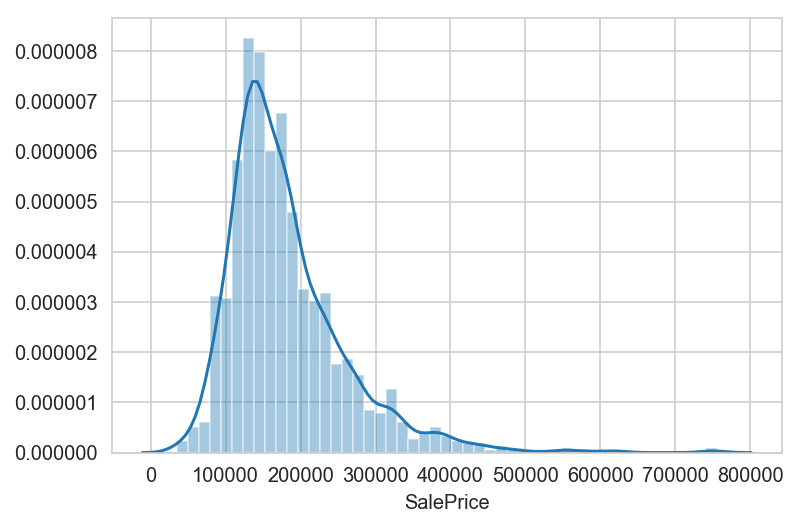

In [17]:
sns.distplot(df['SalePrice'])

In [18]:
print("Skewness: ", df['SalePrice'].skew())
print("Kurtosis: ", df['SalePrice'].kurt())

Skewness:  1.8828757597682129
Kurtosis:  6.536281860064529


C:\Users\Serotonin\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


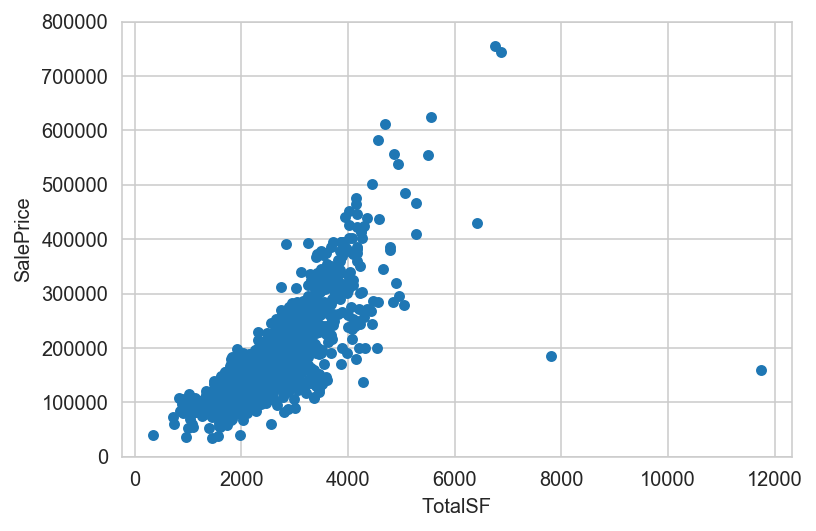

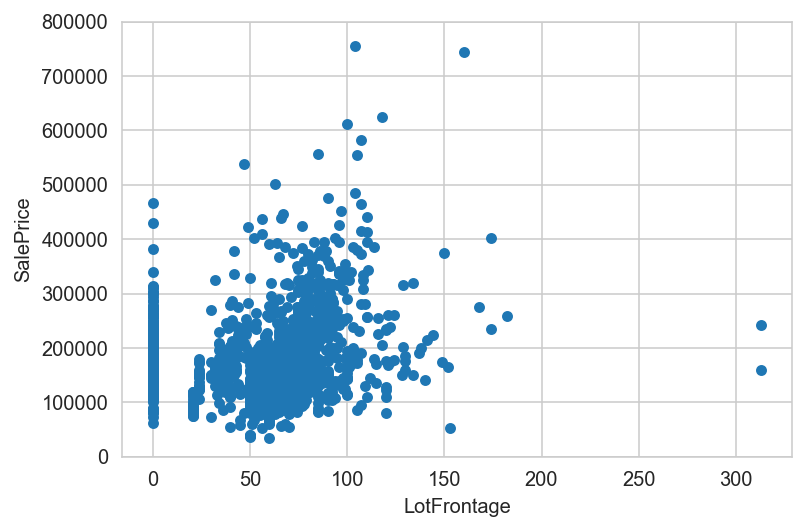

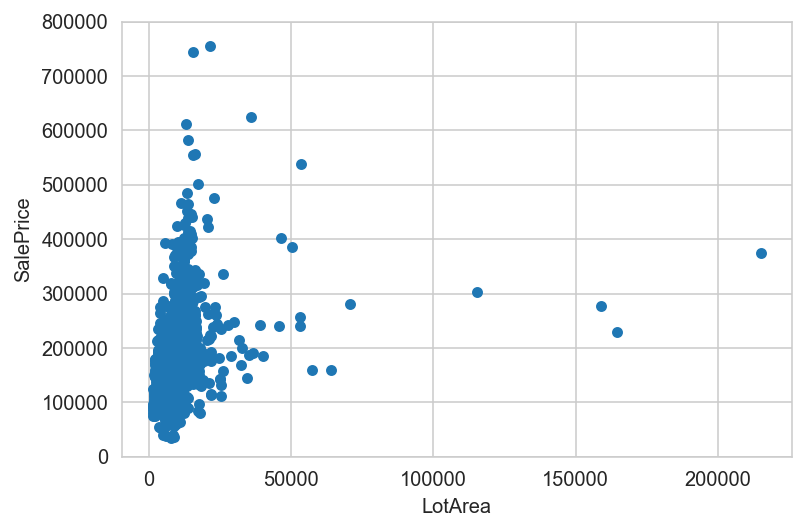

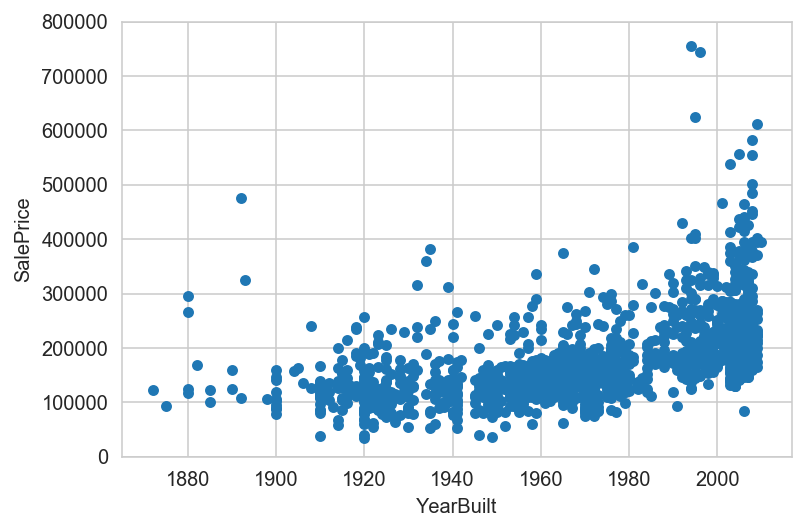

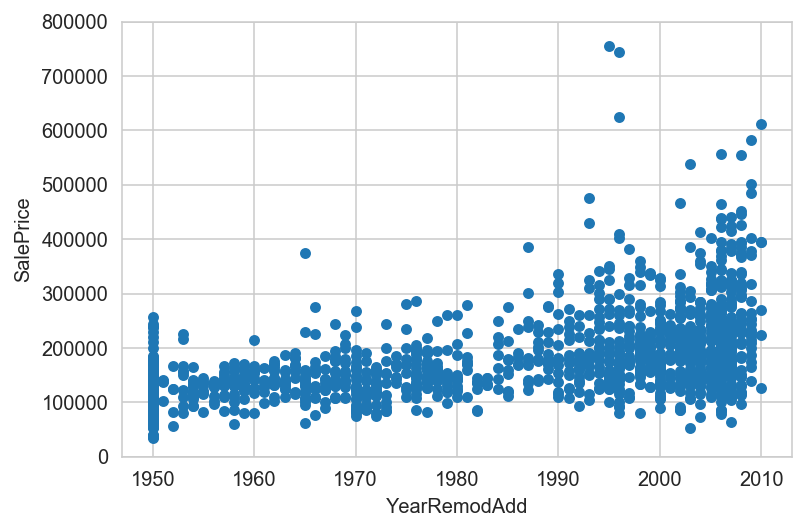

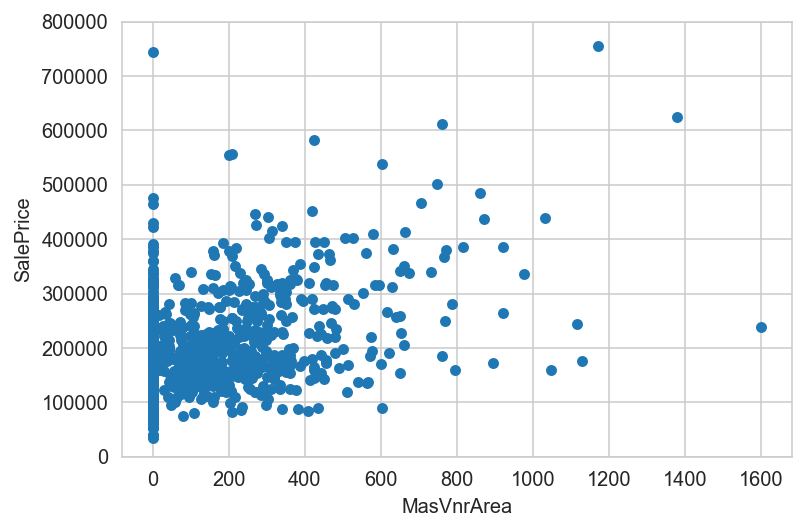

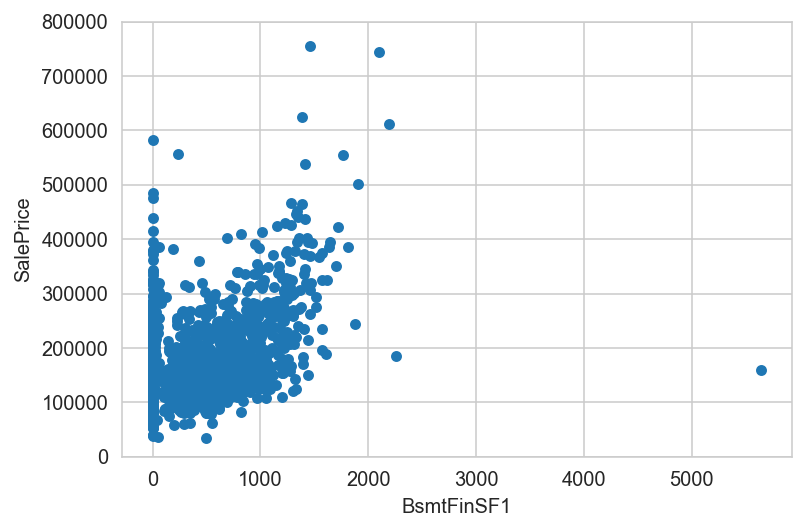

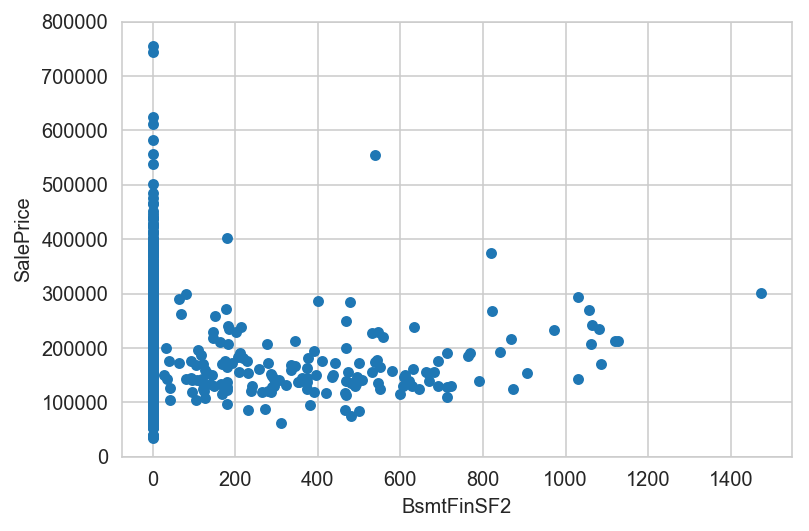

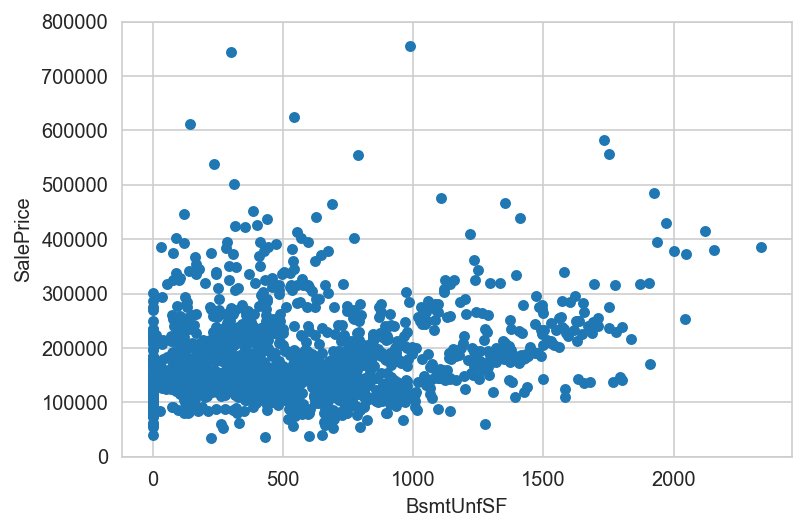

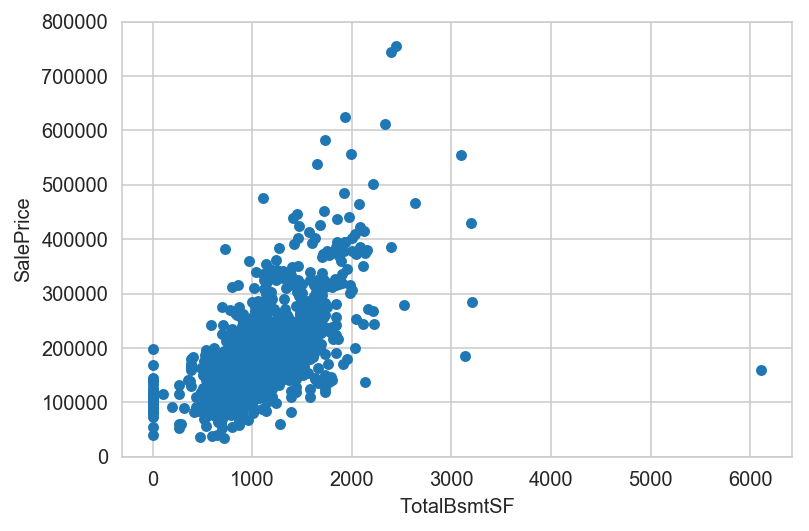

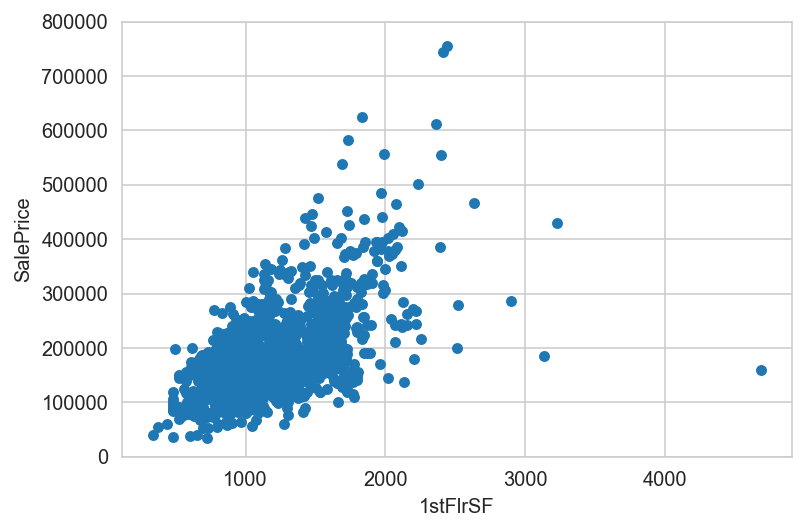

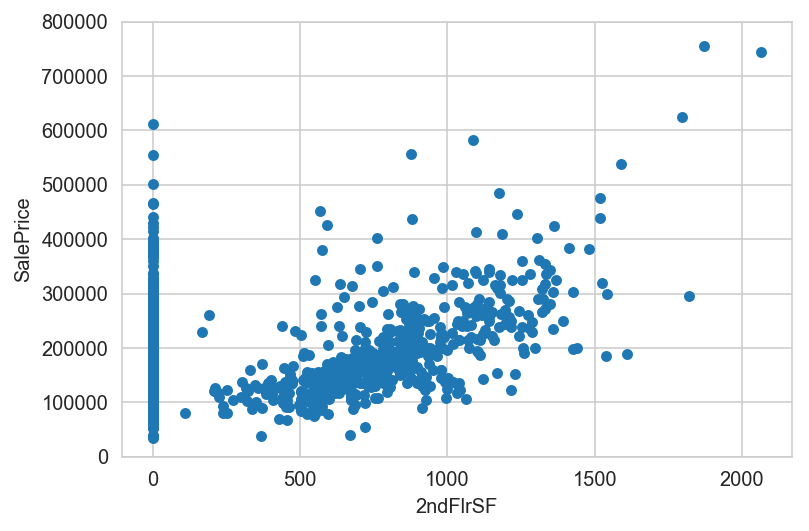

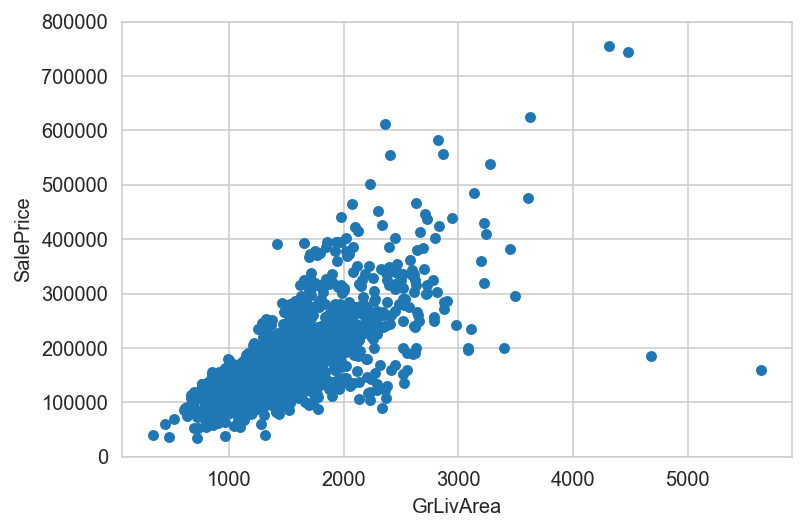

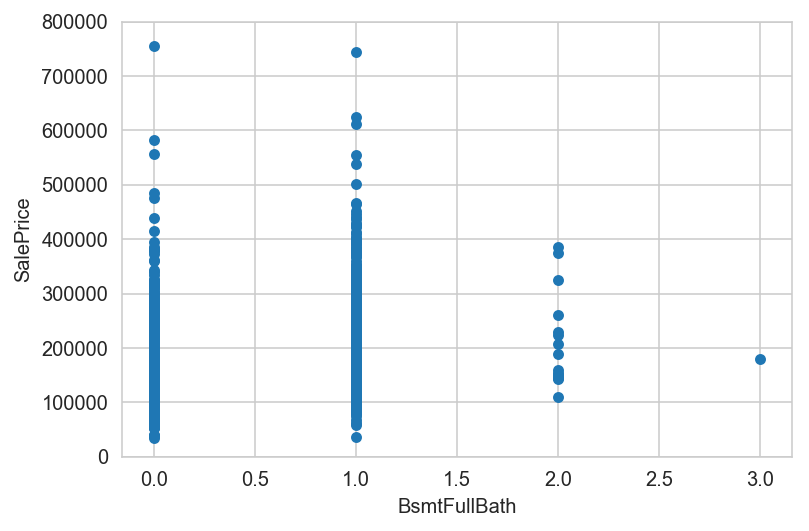

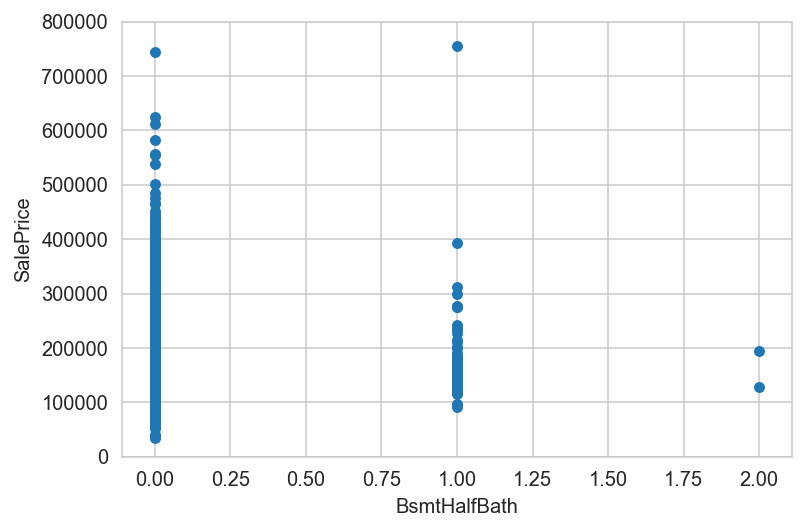

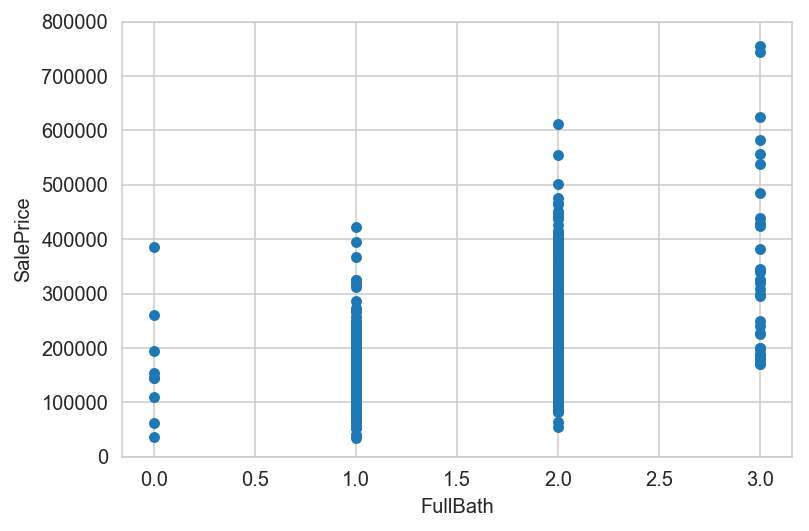

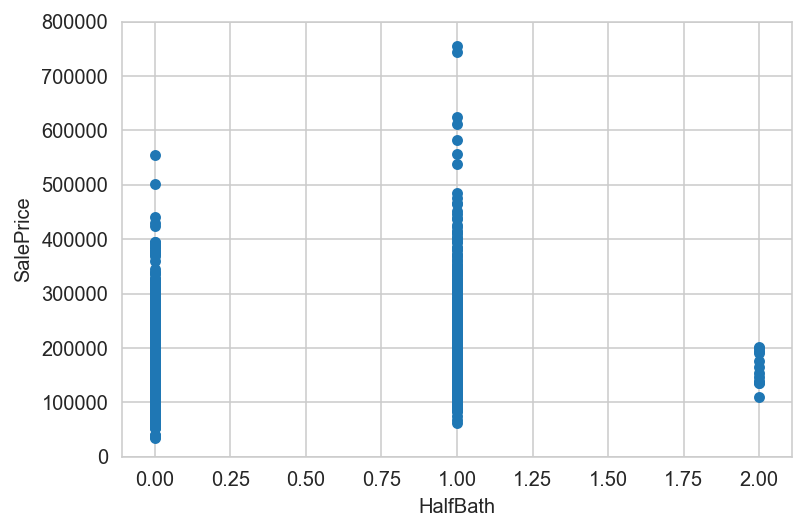

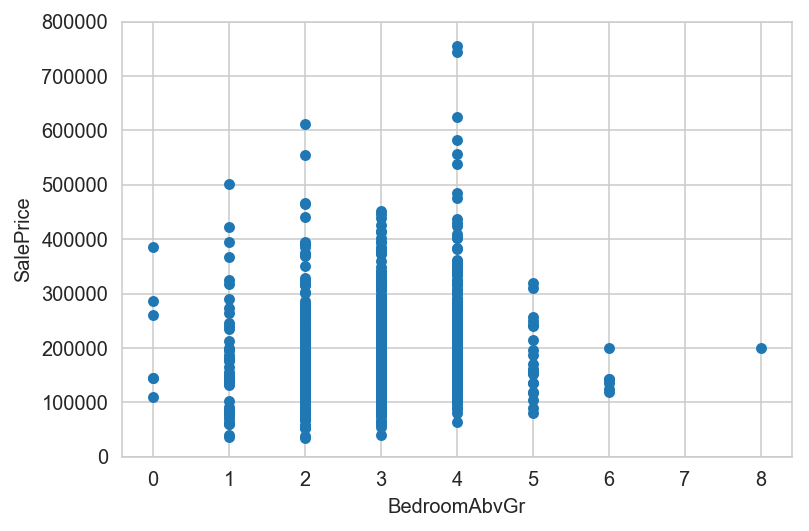

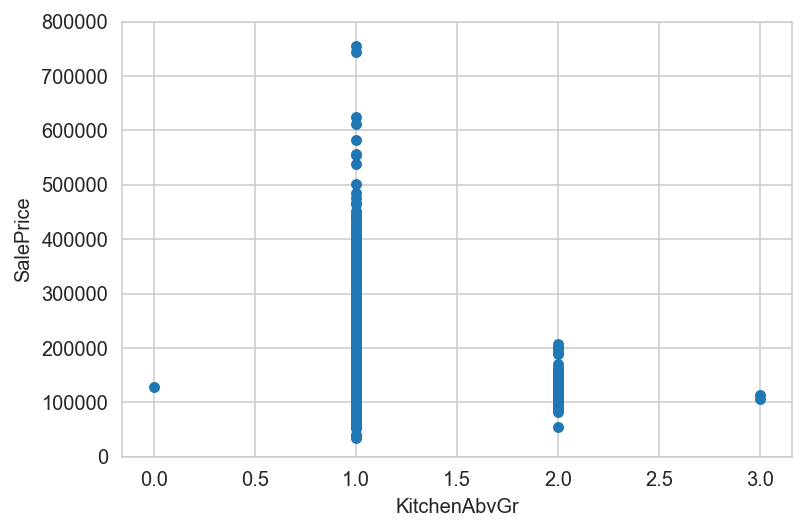

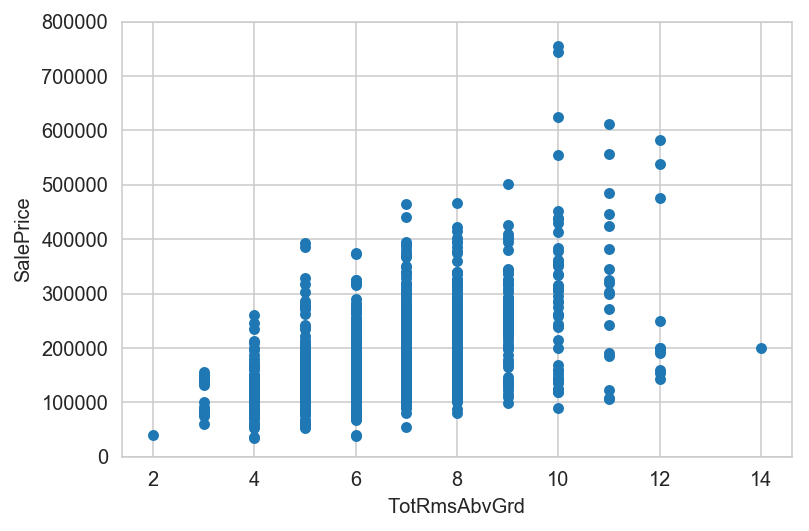

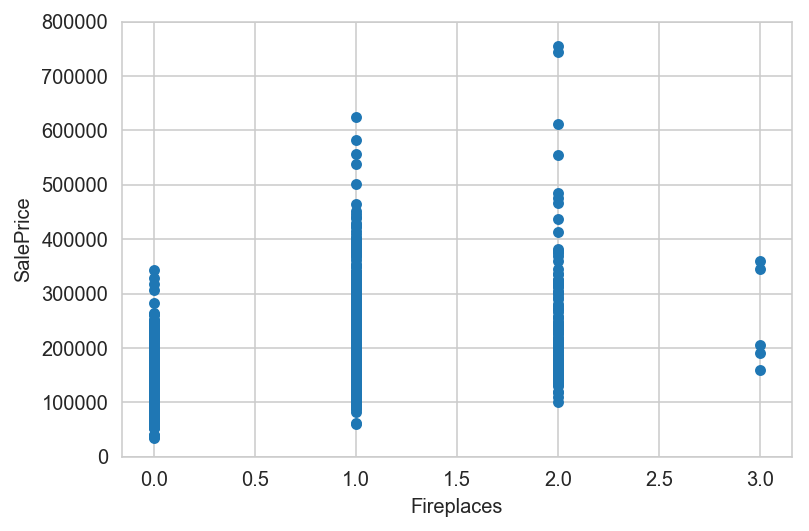

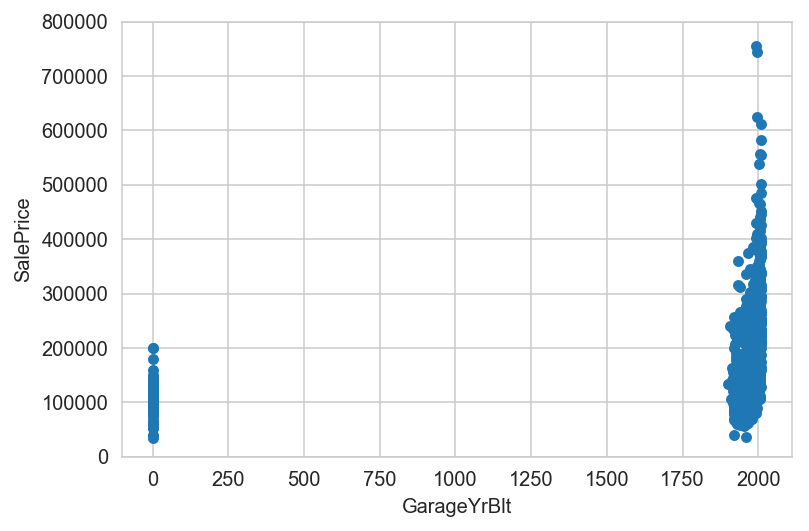

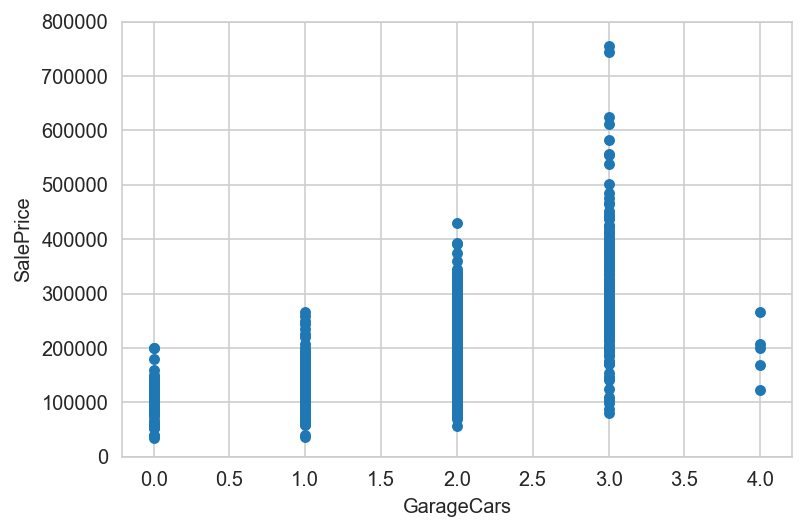

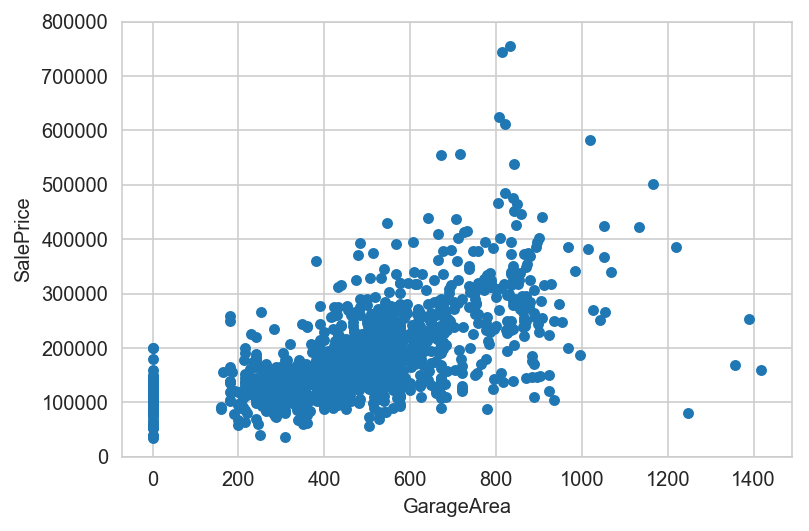

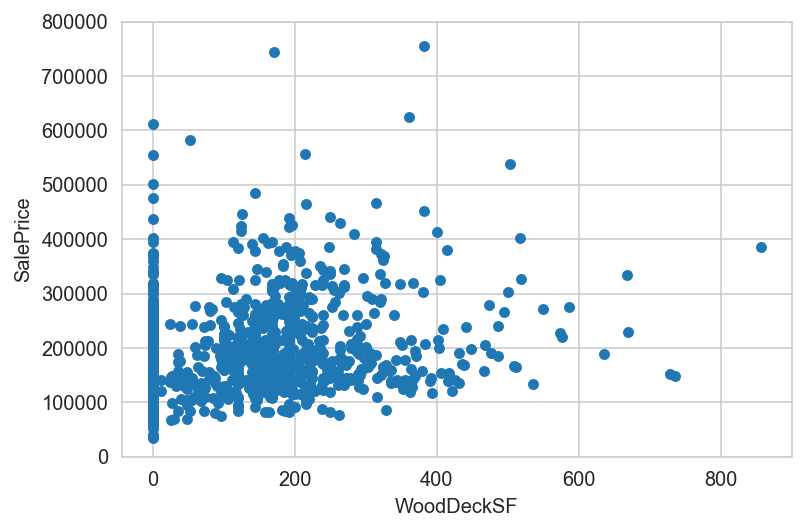

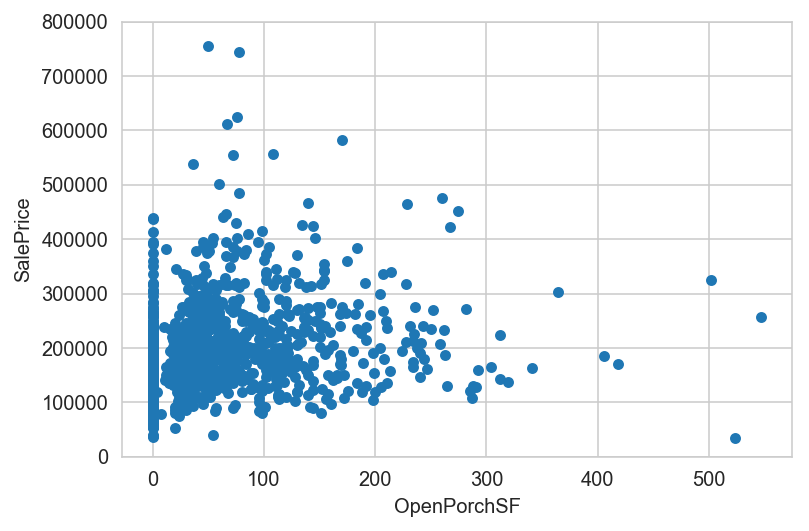

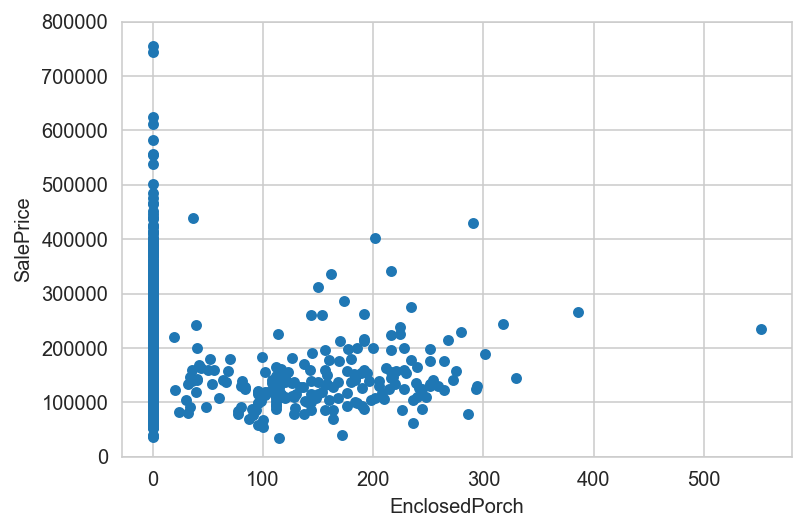

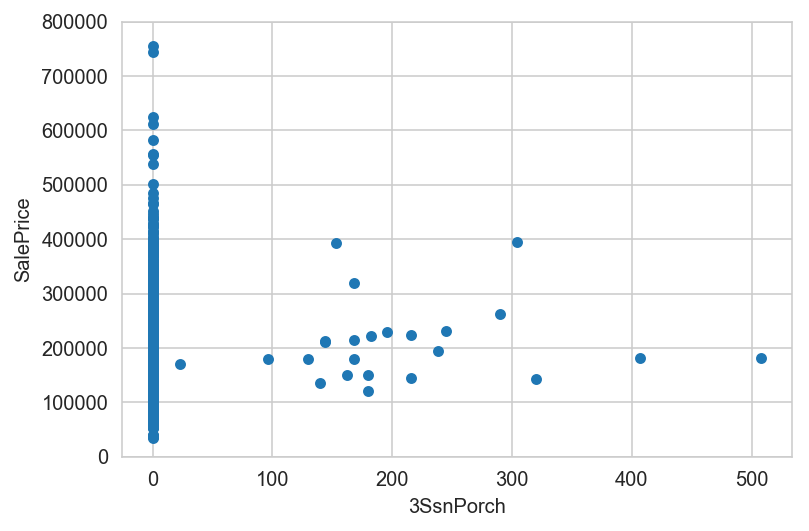

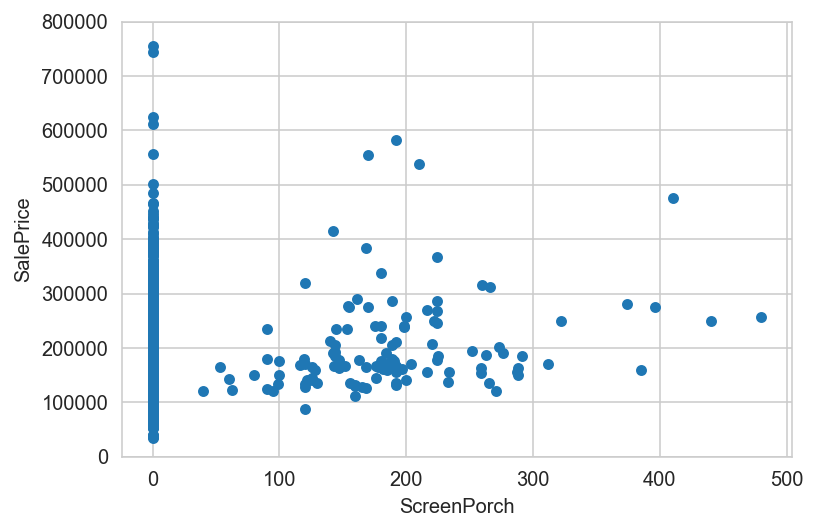

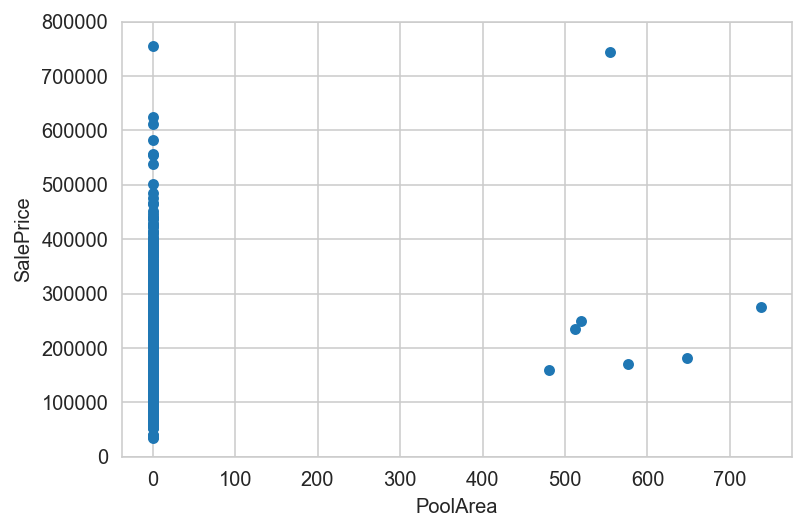

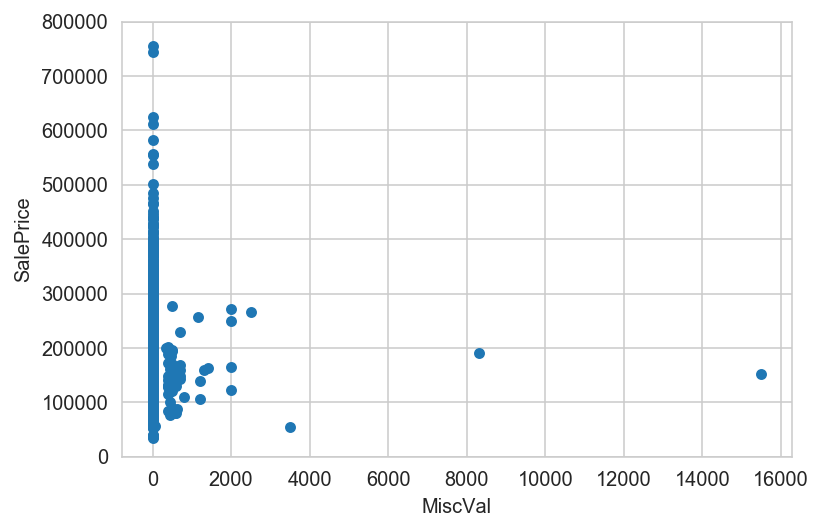

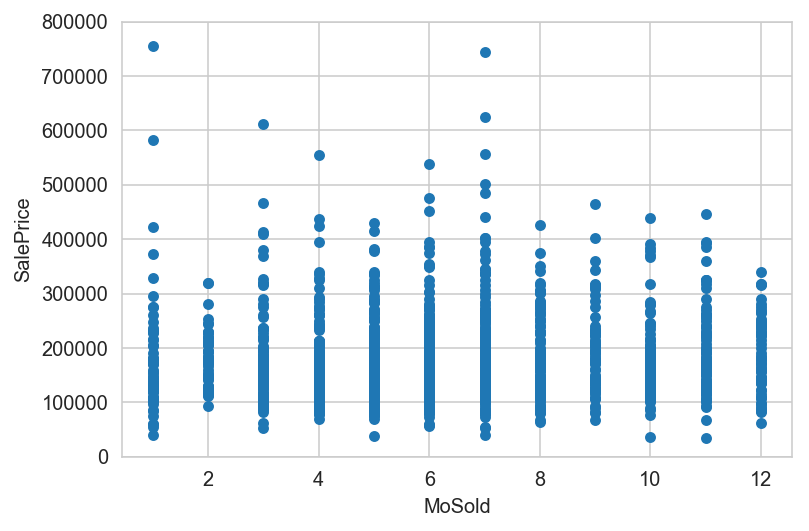

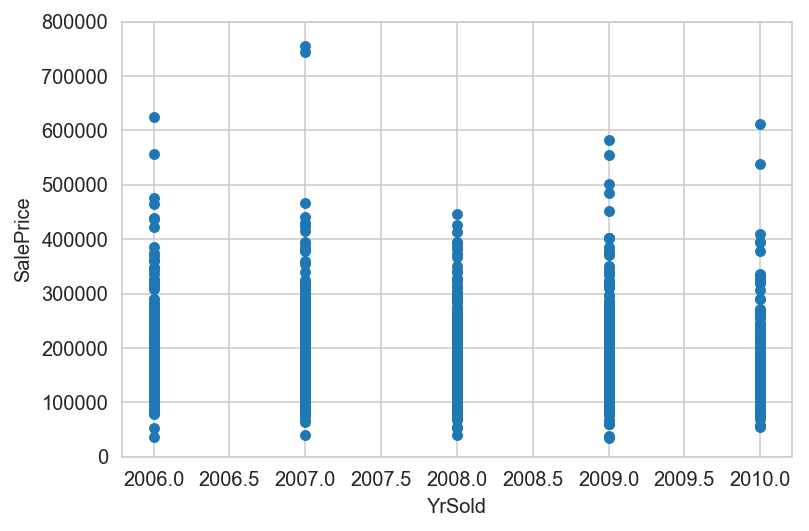

In [19]:
for fixed in housedict['fixed']:
    if df[fixed].dtypes != object:
        data = pd.concat([df['SalePrice'], df[fixed]], axis=1)
        data.plot.scatter(x=fixed, y='SalePrice', ylim=(0,800000))

(-0.5, 9.5, 0, 800000)

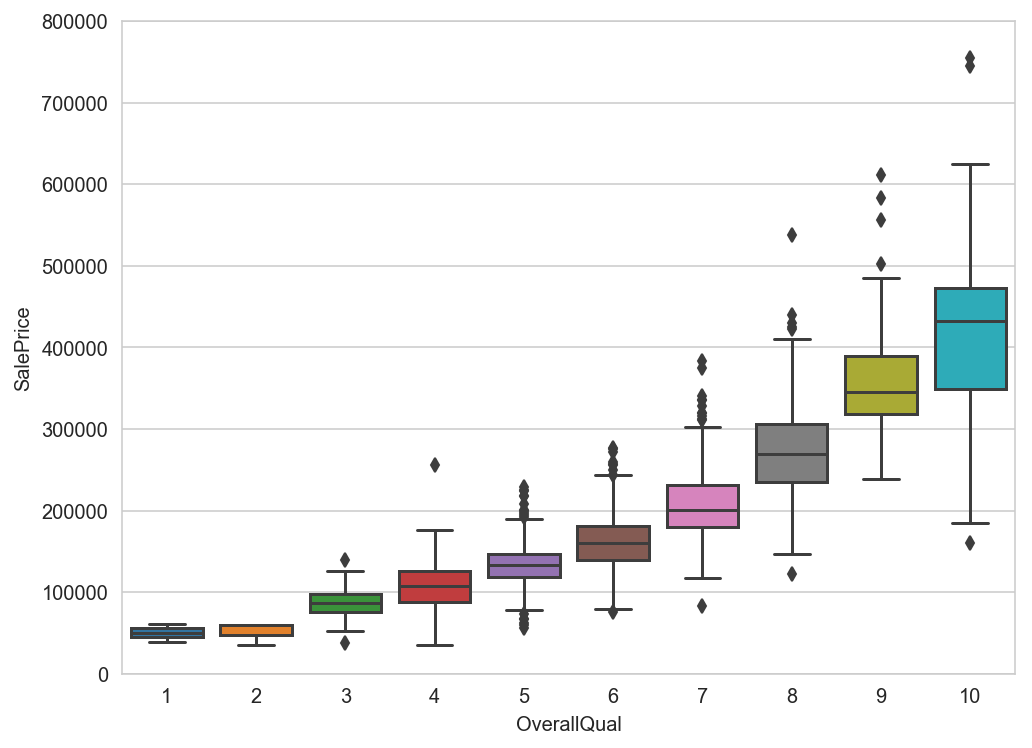

In [20]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

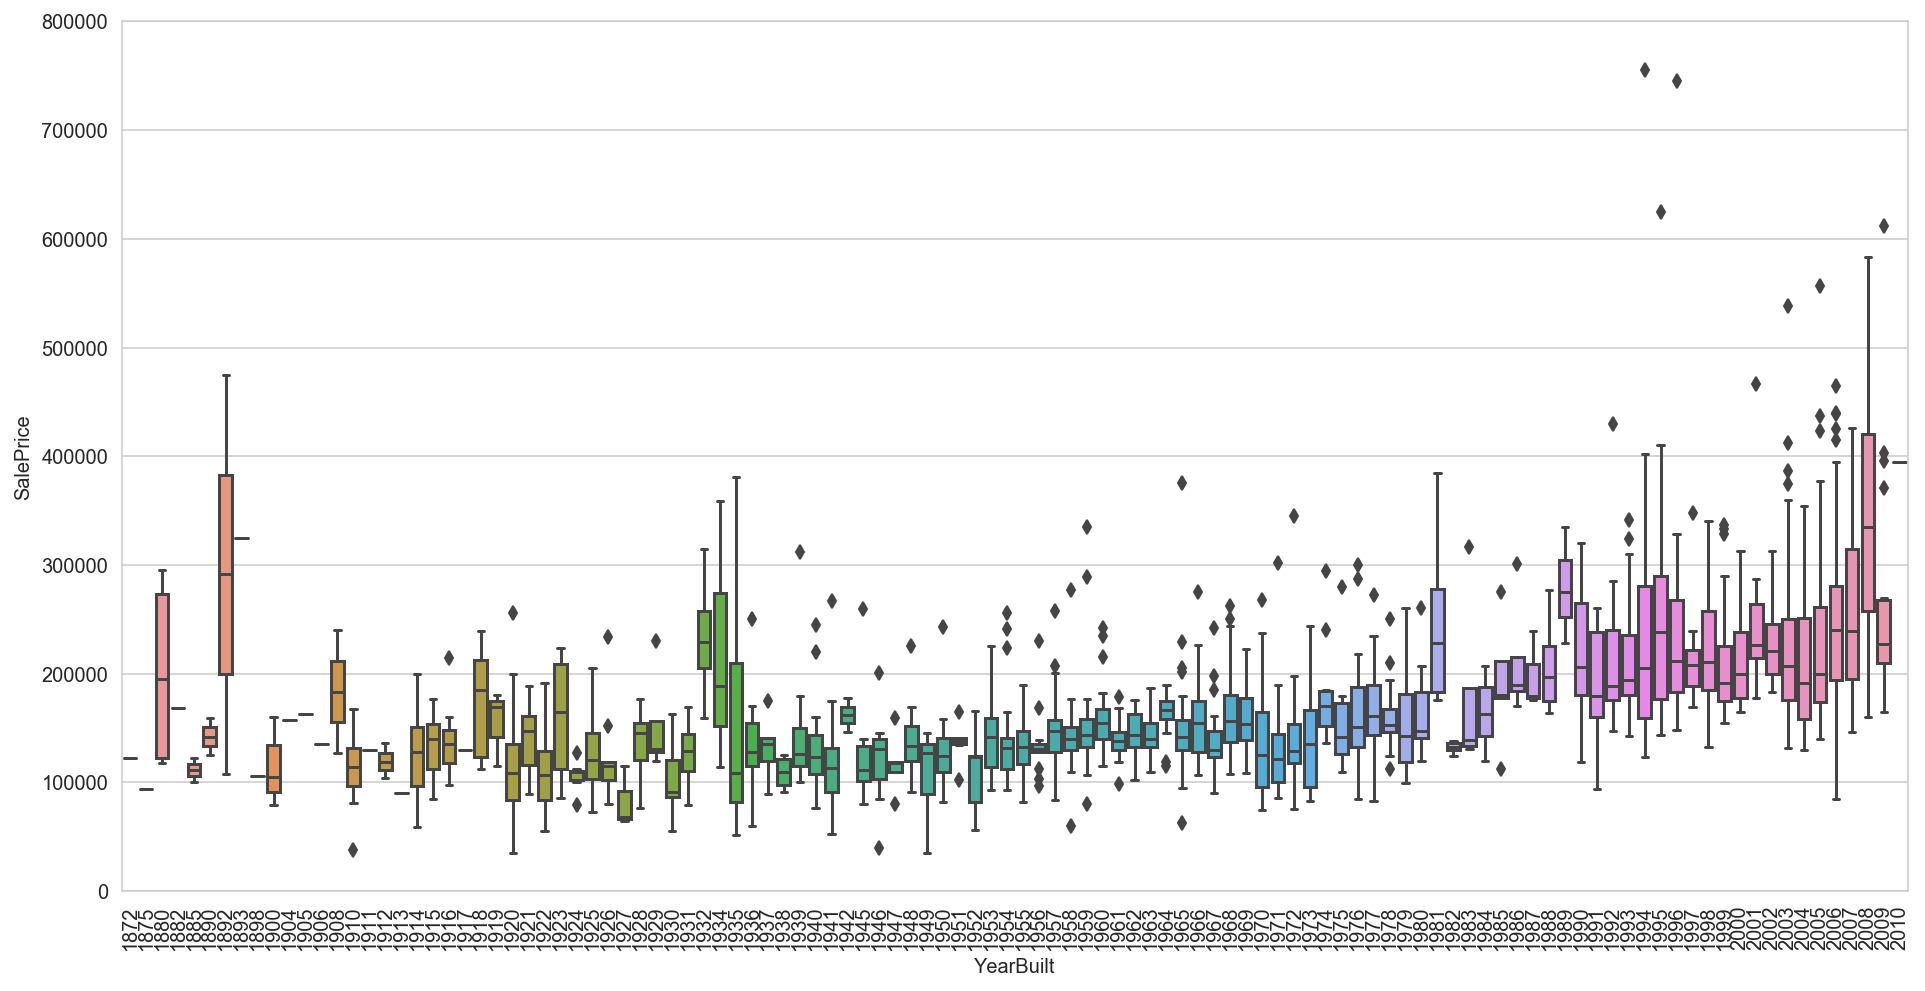

In [21]:
var = 'YearBuilt'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90)

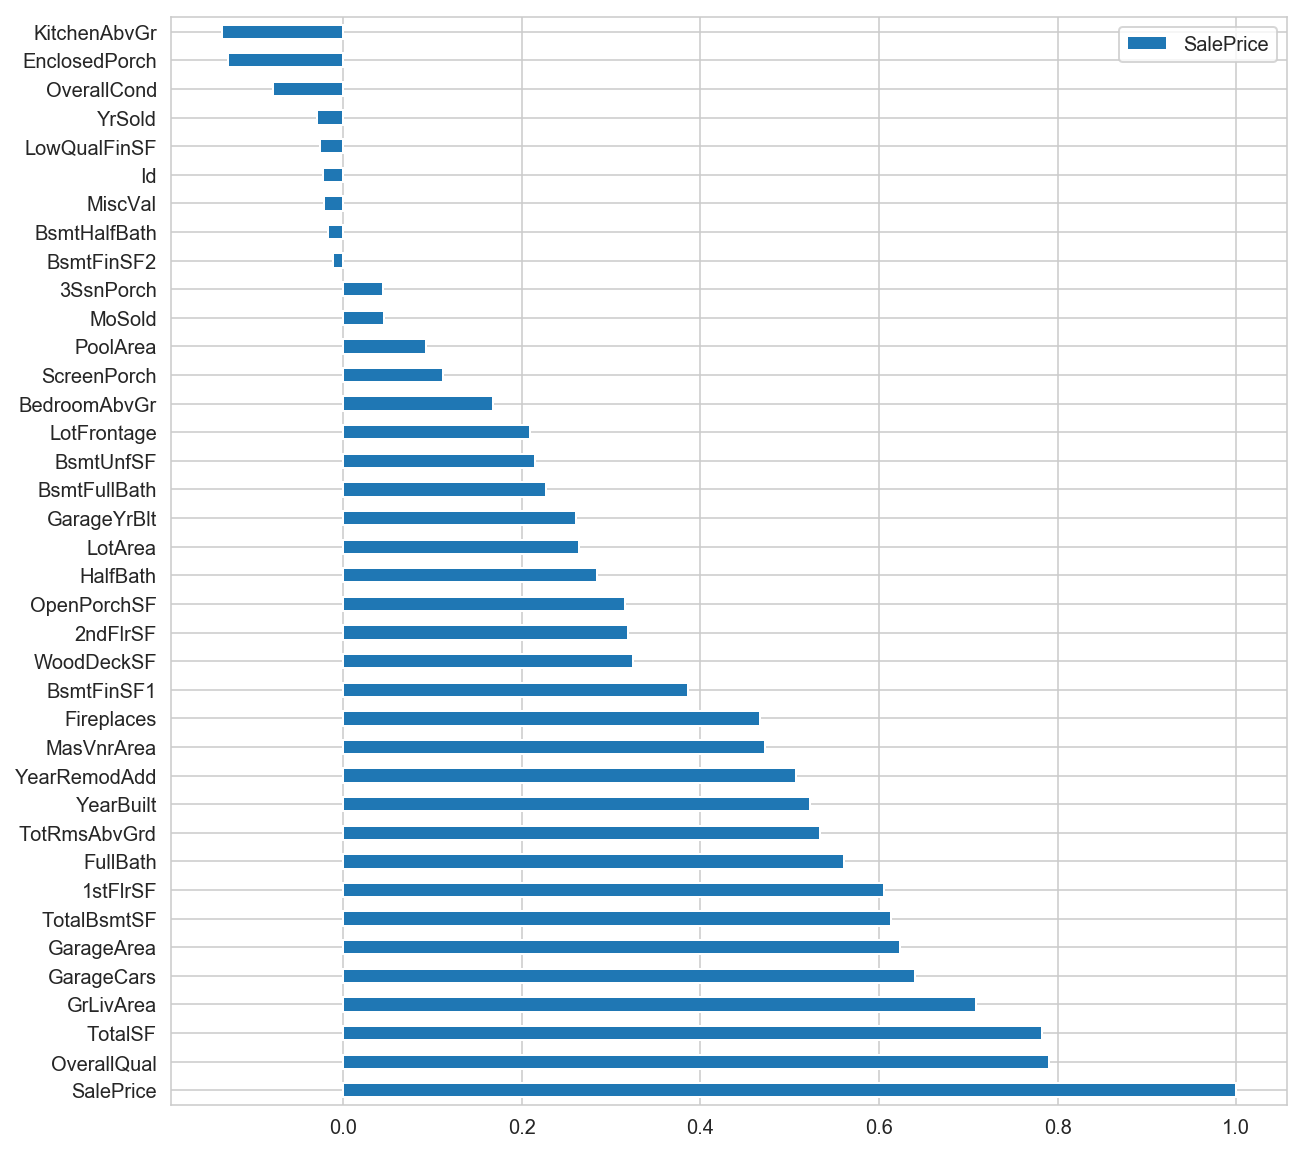

In [22]:
Corrlist = df.corr()[['SalePrice']].sort_values('SalePrice',axis=0, ascending=False)
Corrlist['Correlation'] = Corrlist.index

Corrlist.plot.barh(figsize=[10,10])

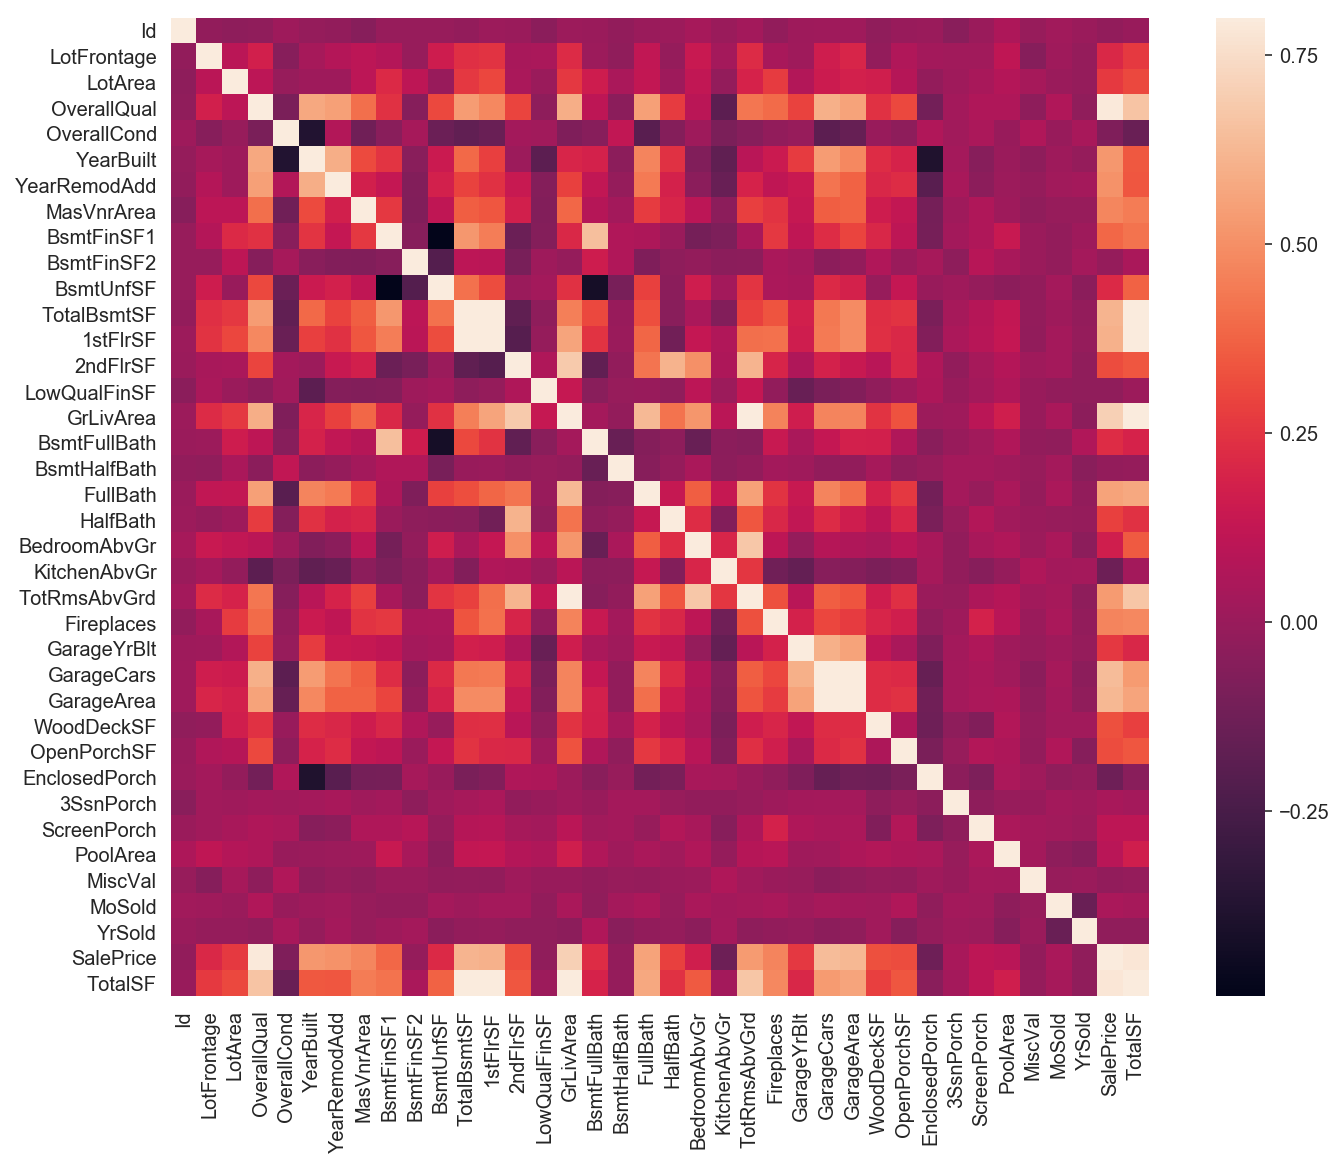

In [23]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

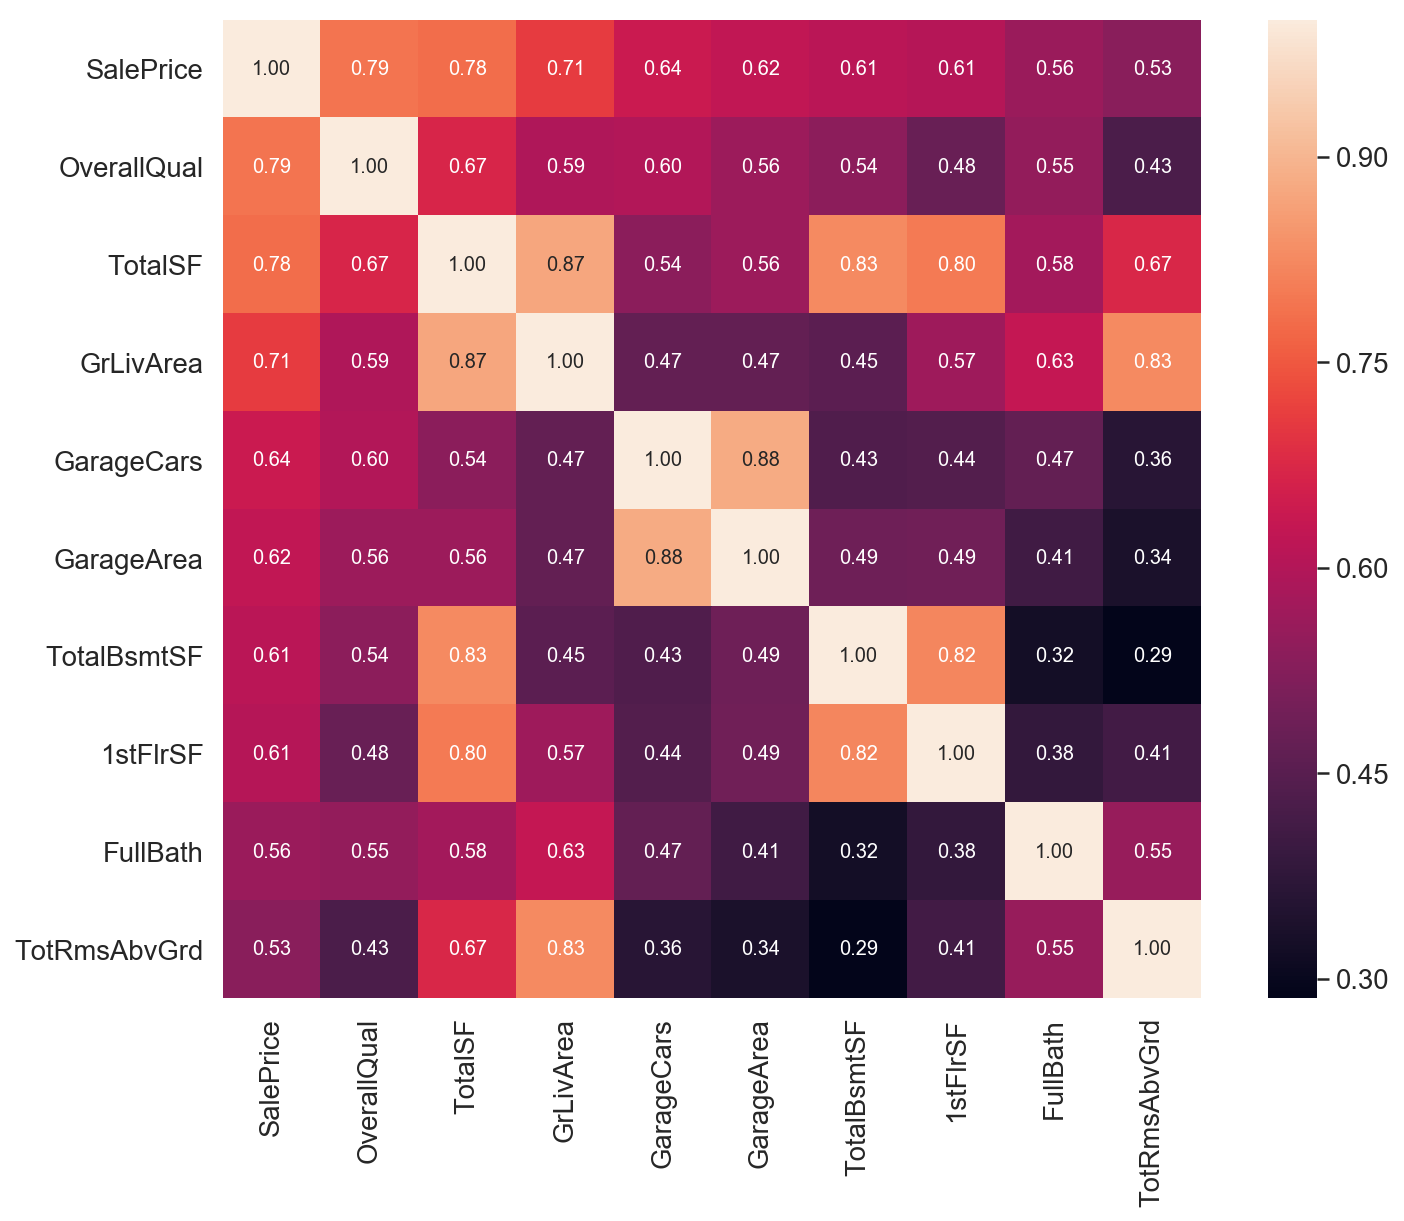

In [24]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [25]:
cols

Index(['SalePrice', 'OverallQual', 'TotalSF', 'GrLivArea', 'GarageCars',
       'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd'],
      dtype='object')

<Figure size 432x288 with 0 Axes>

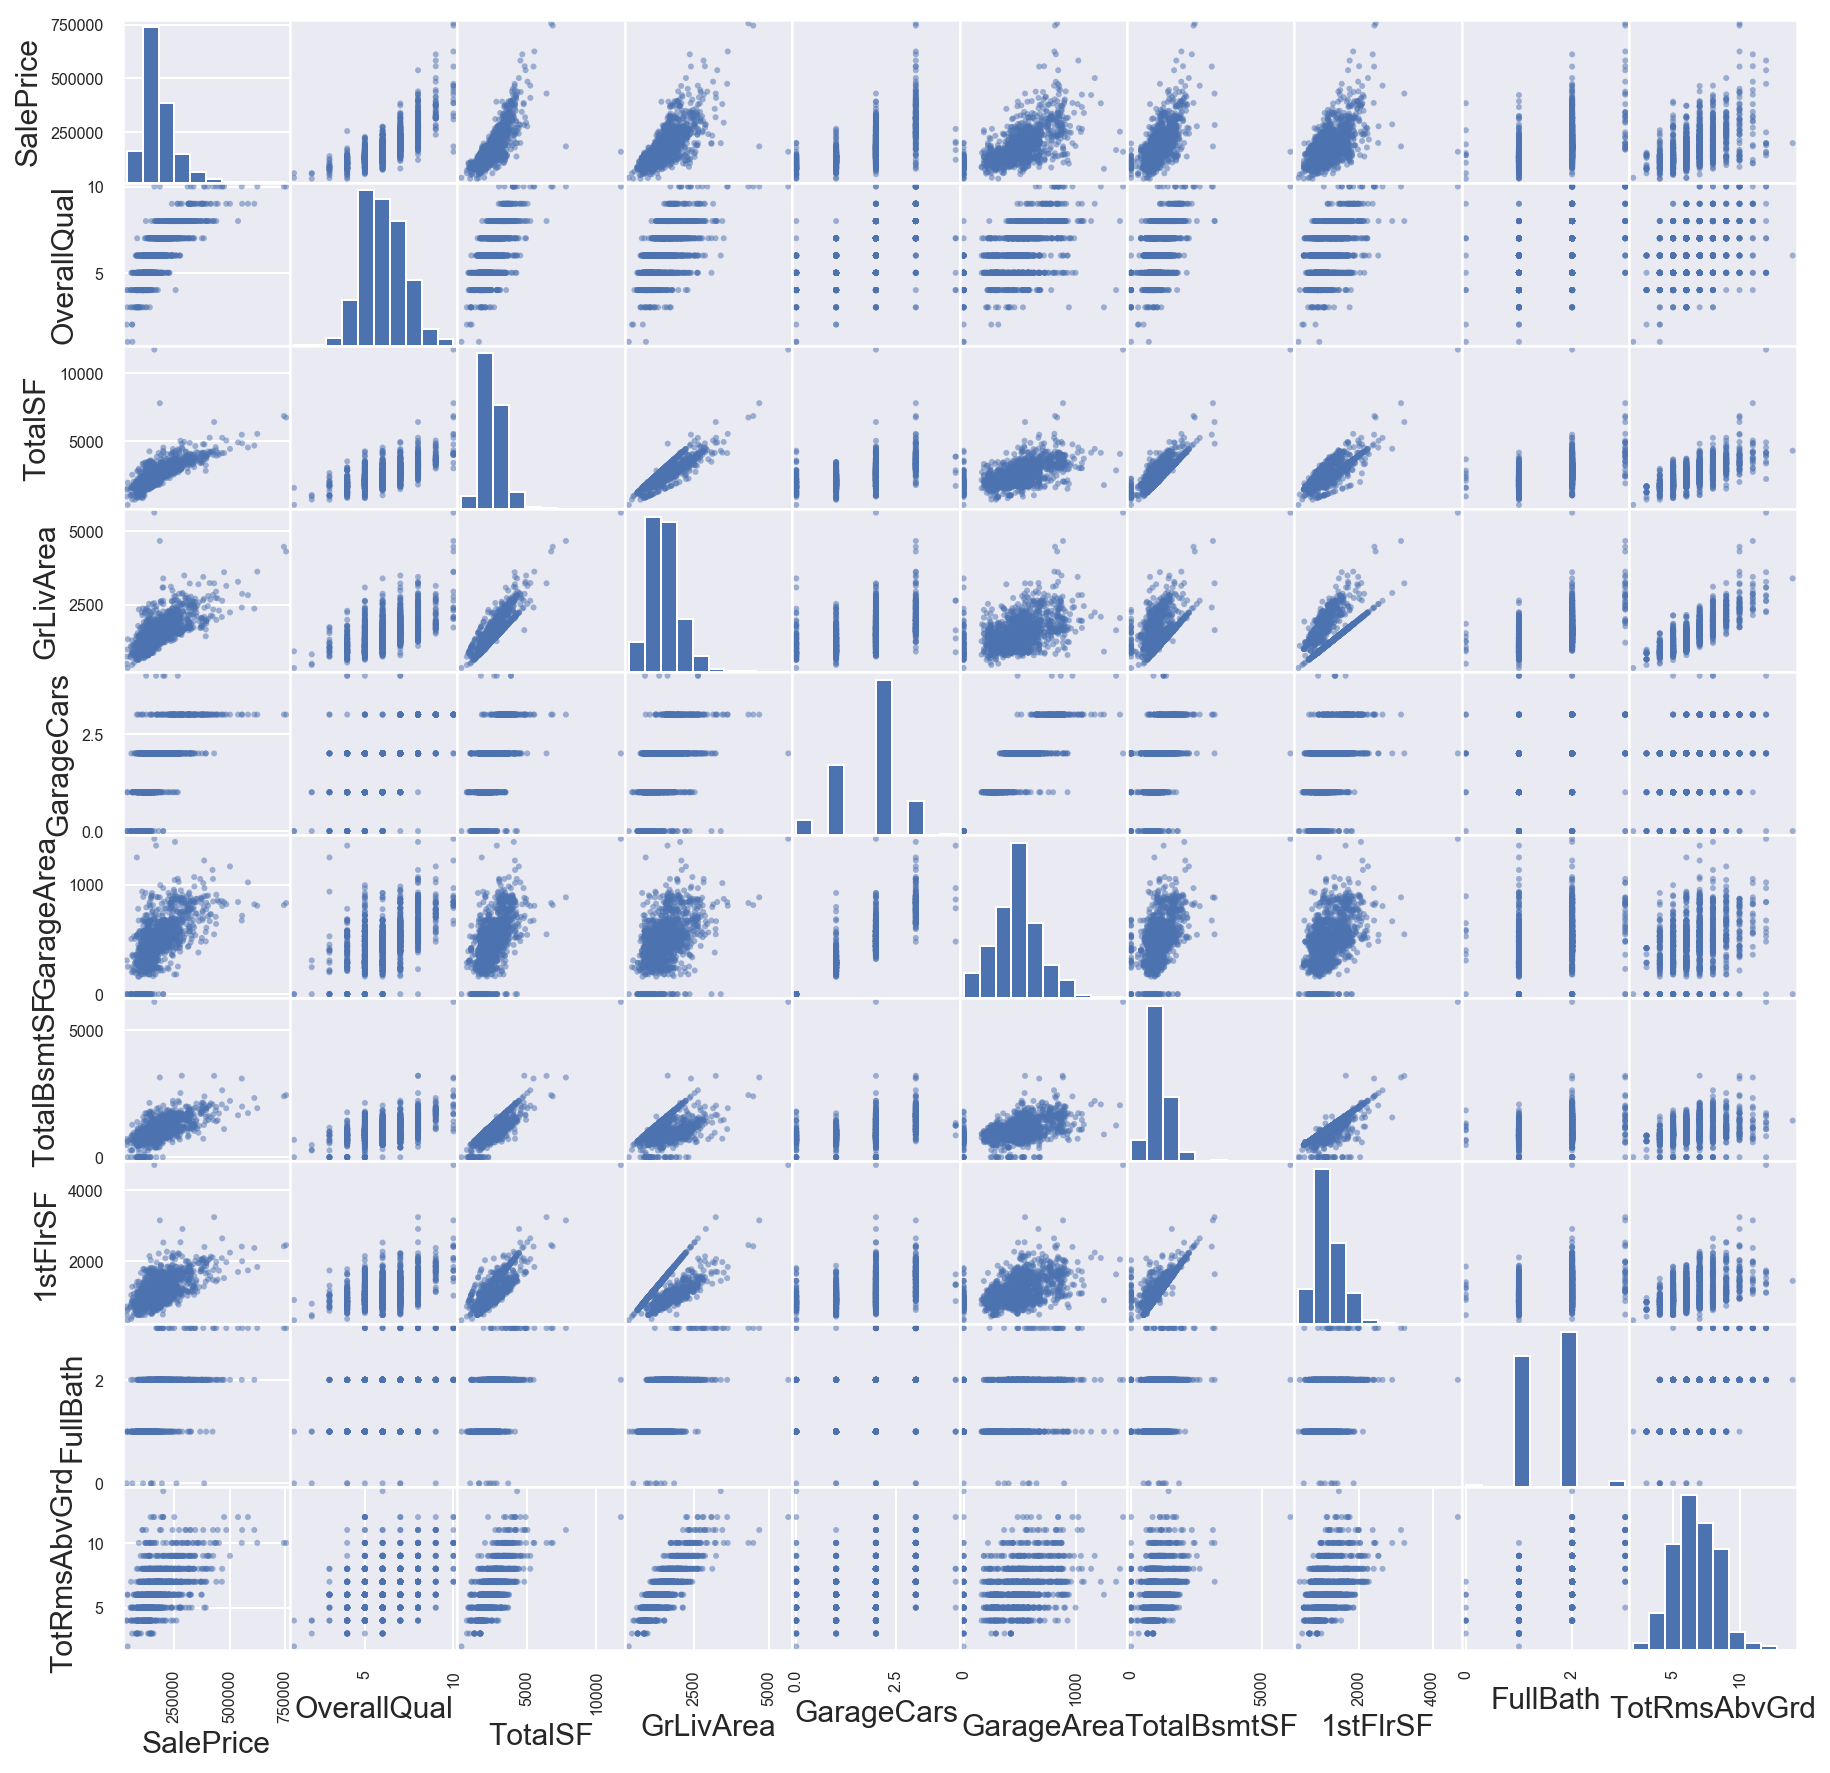

<Figure size 432x288 with 0 Axes>

In [26]:
pd.plotting.scatter_matrix(df[cols],figsize=(15,15))
plt.figure()


C:\Users\Serotonin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


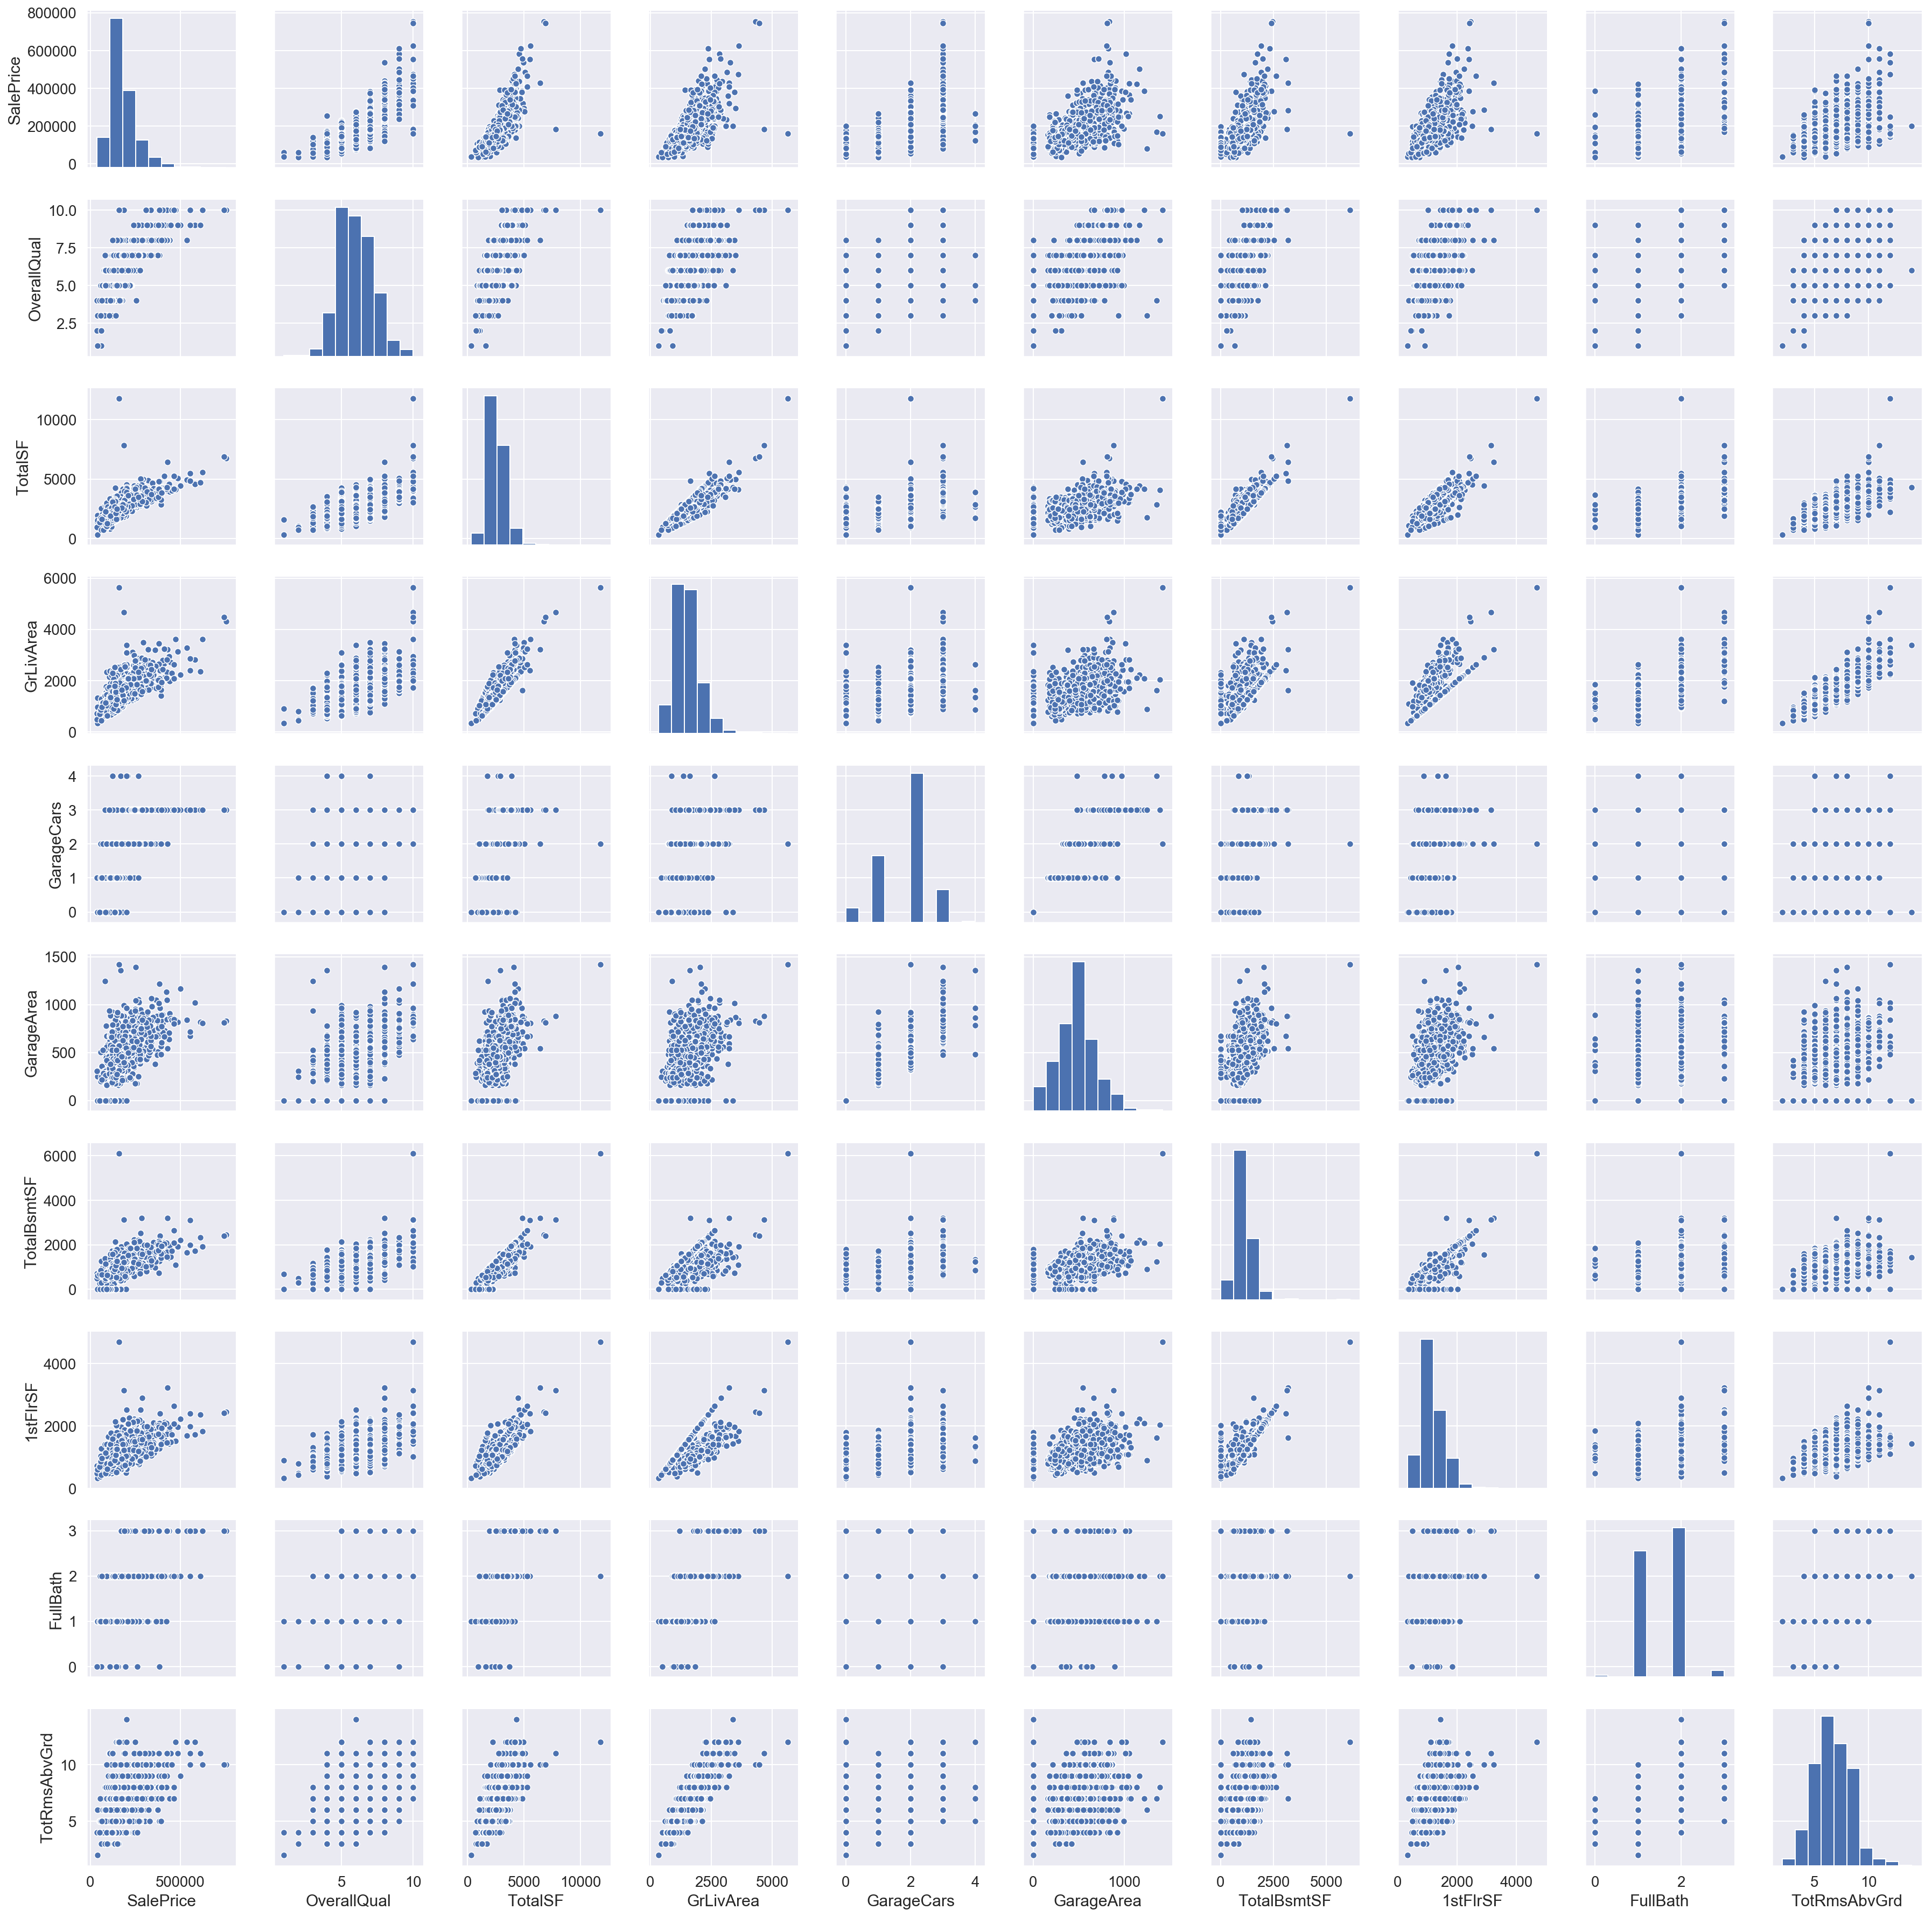

In [27]:
sns.pairplot(df[cols], size = 2.5)
plt.show();

In [28]:
df.isnull().sum().sum()


0

In [ ]:
#outliers

#fig, ax = plt.subplots()
#ax.scatter(x = df['GrLivArea'], y = df['SalePrice'])
#plt.ylabel('SalePrice', fontsize=13)
#plt.xlabel('GrLivArea', fontsize=13)
#plt.show()

In [ ]:
#df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)

#Check the graphic again
#fig, ax = plt.subplots()
#ax.scatter(df['GrLivArea'], df['SalePrice'])
#plt.ylabel('SalePrice', fontsize=13)
#plt.xlabel('GrLivArea', fontsize=13)
#plt.show()

## Dealing with outliers

In [30]:

floatcolumns = [column for column in df.columns if df[column].dtype != object]
floatcolumns.remove('YrSold')
floatcolumns.remove('MoSold')
Scale = StandardScaler()


In [31]:
from sklearn.neighbors import LocalOutlierFactor

In [32]:
Scale = StandardScaler()

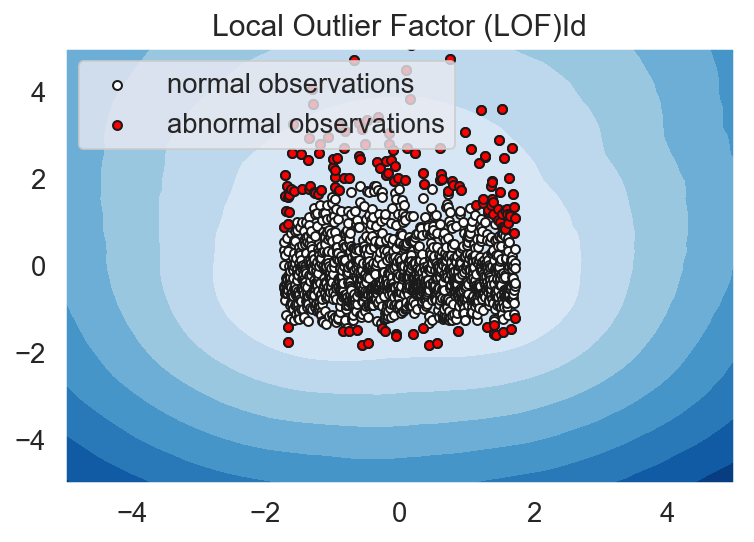

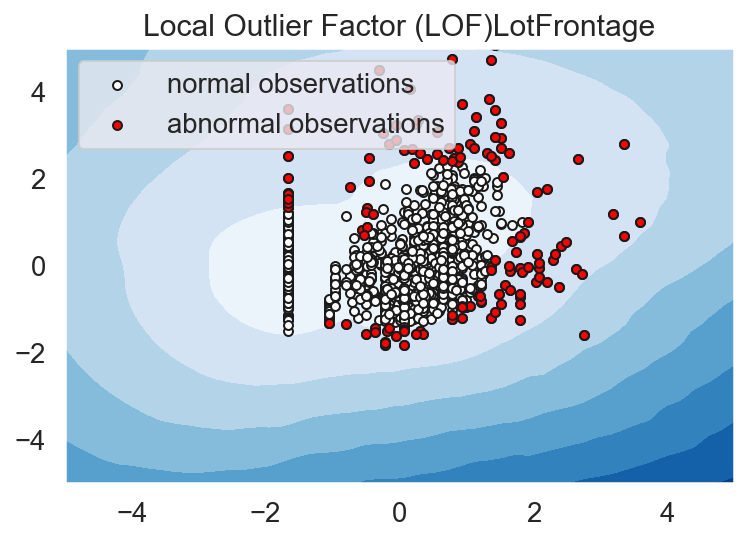

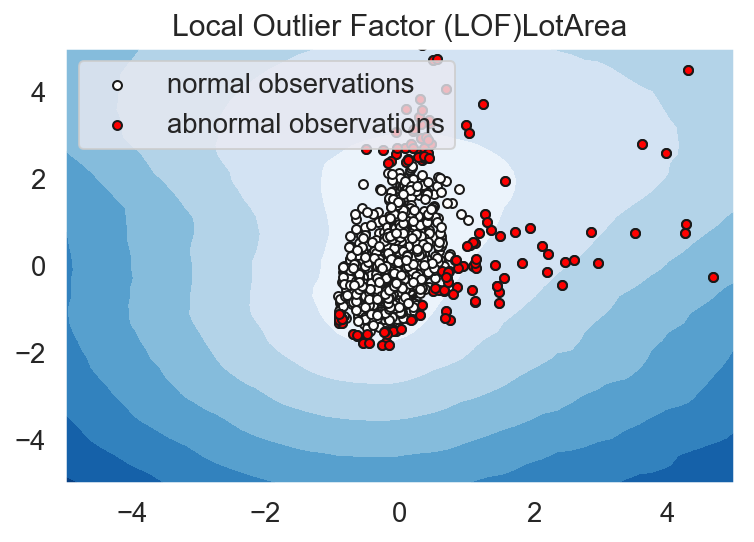

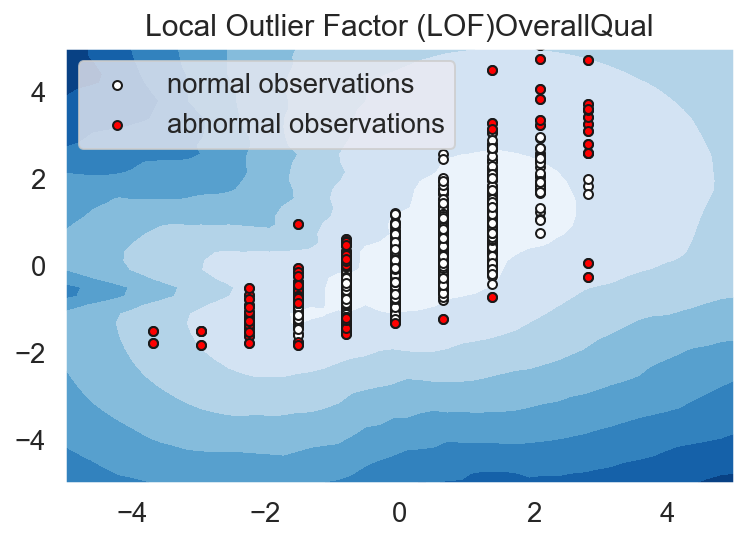

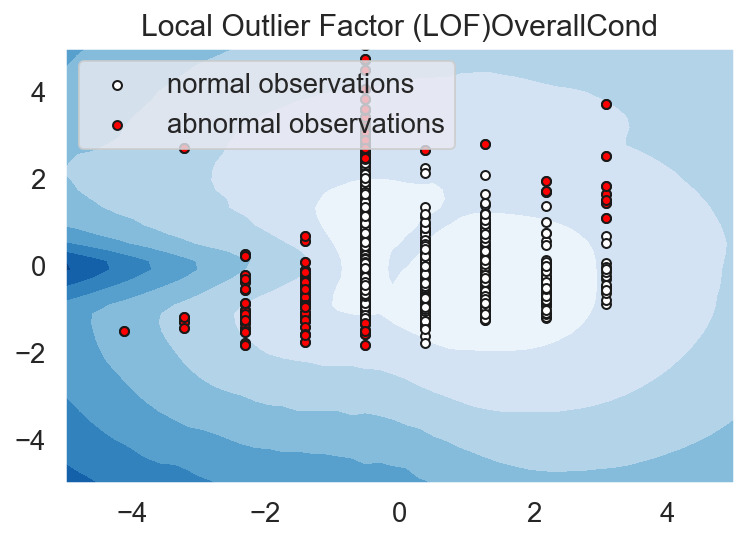

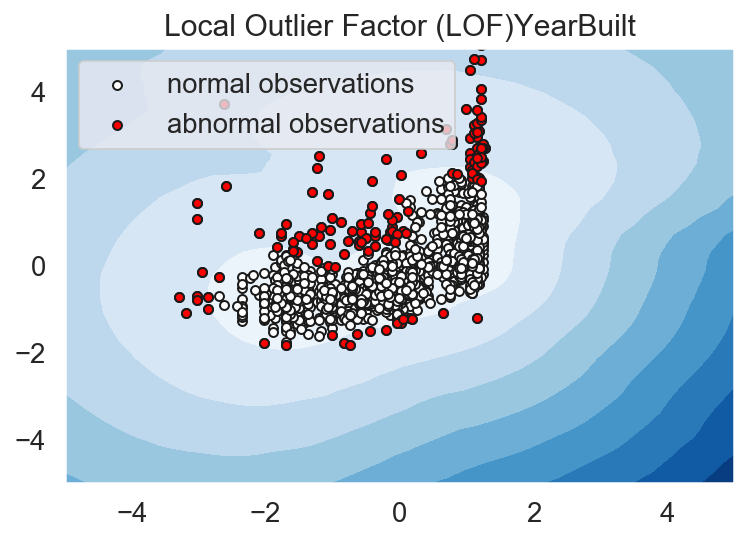

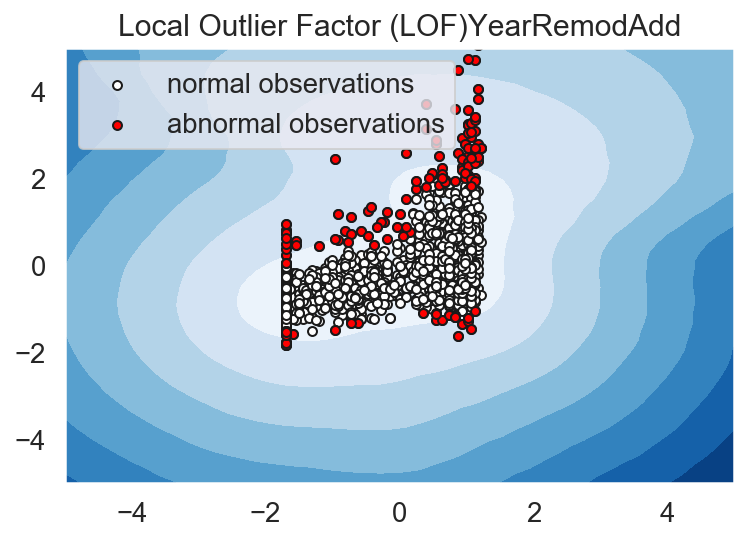

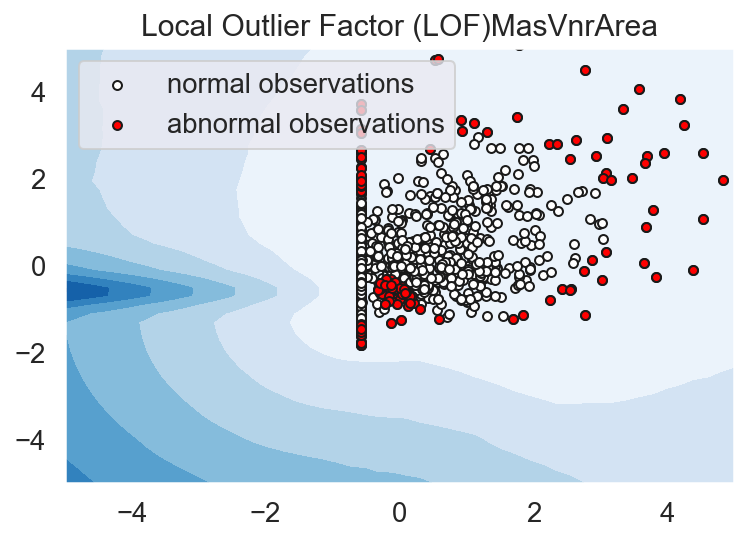

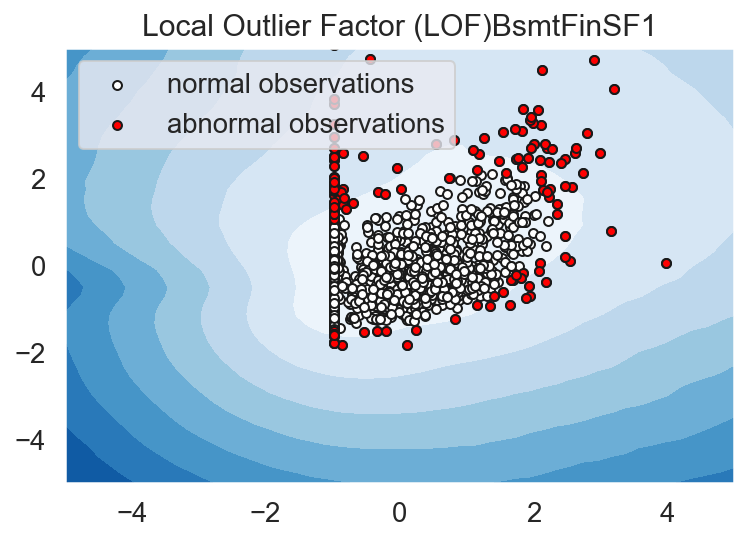

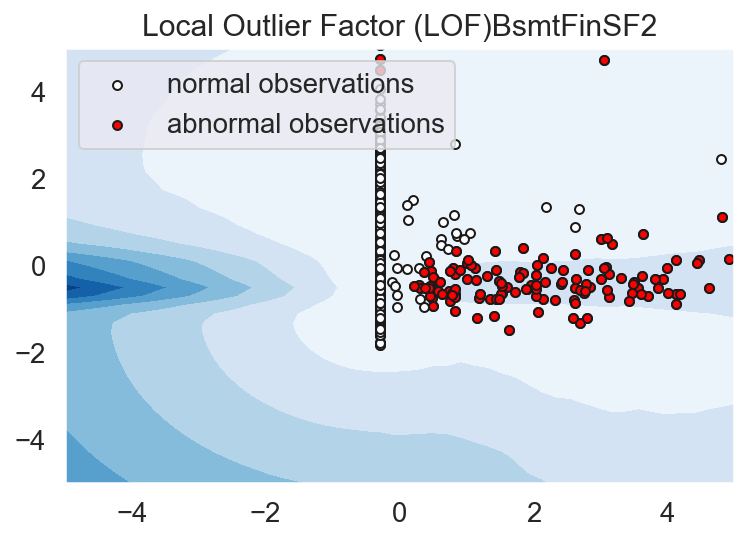

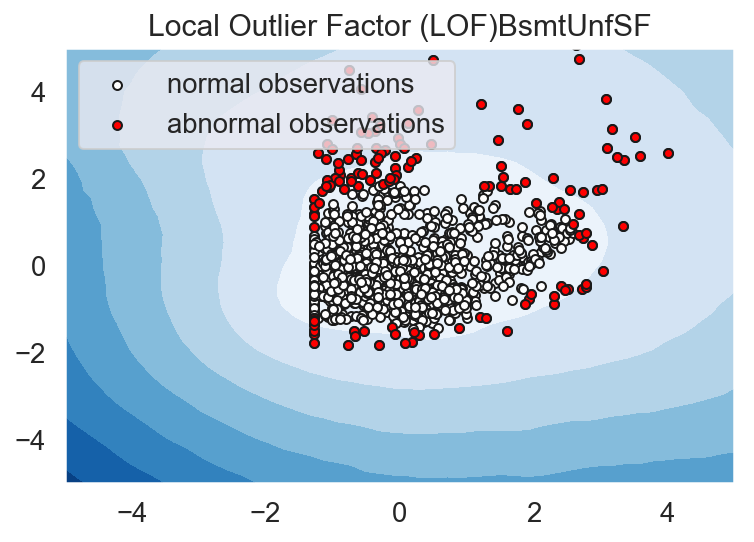

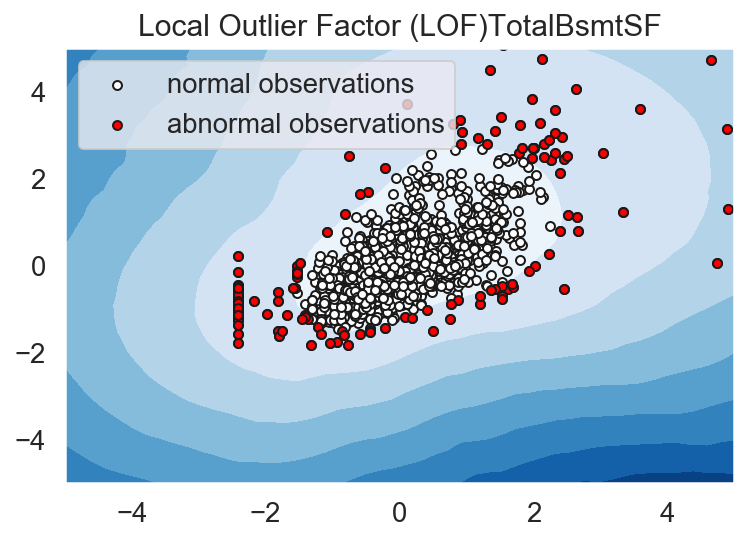

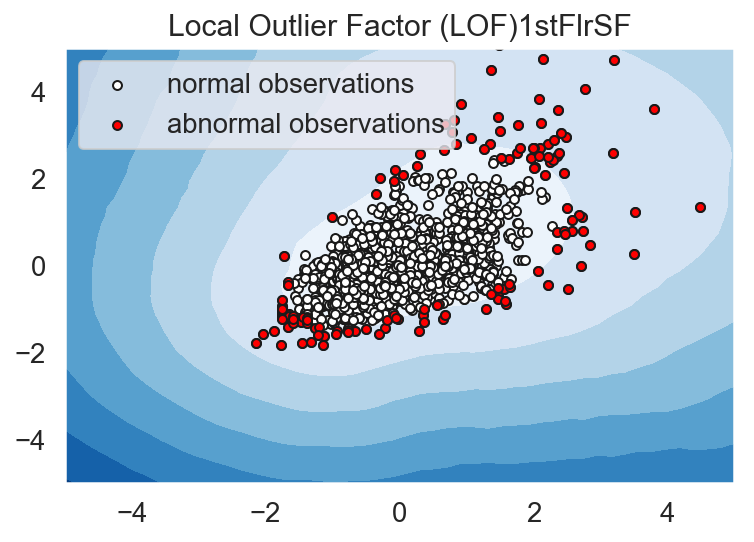

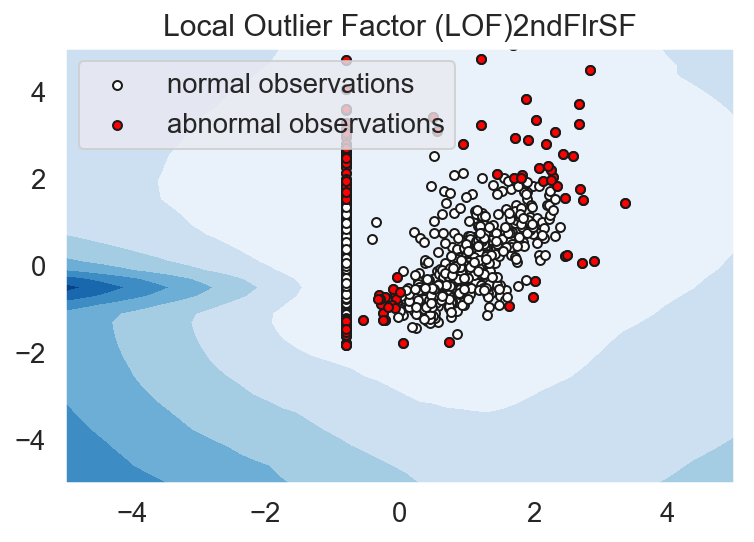

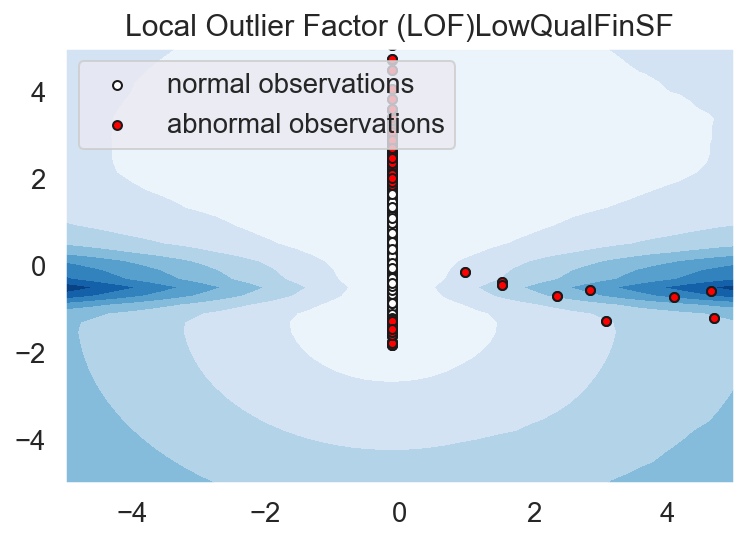

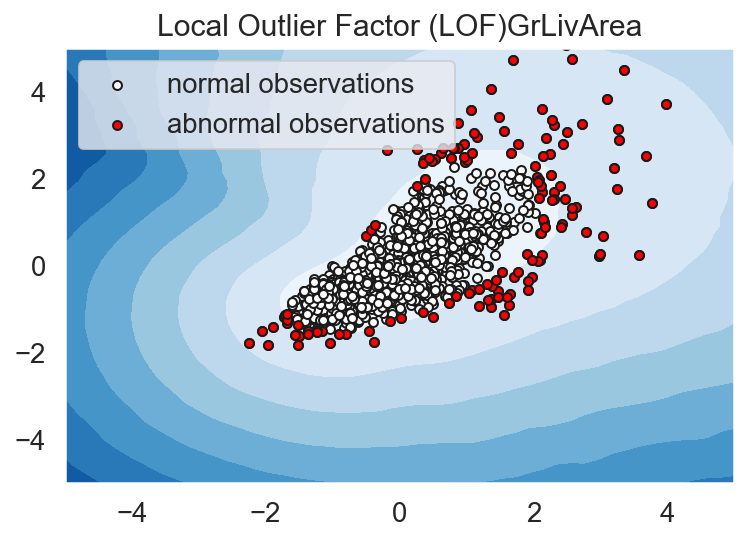

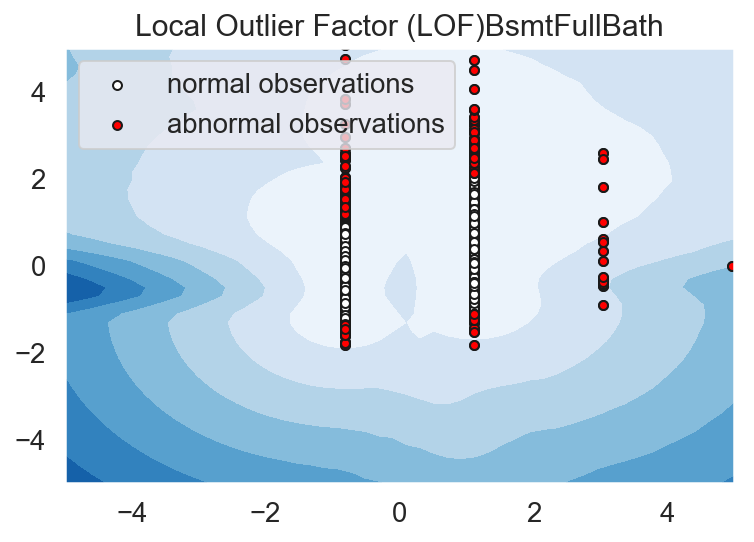

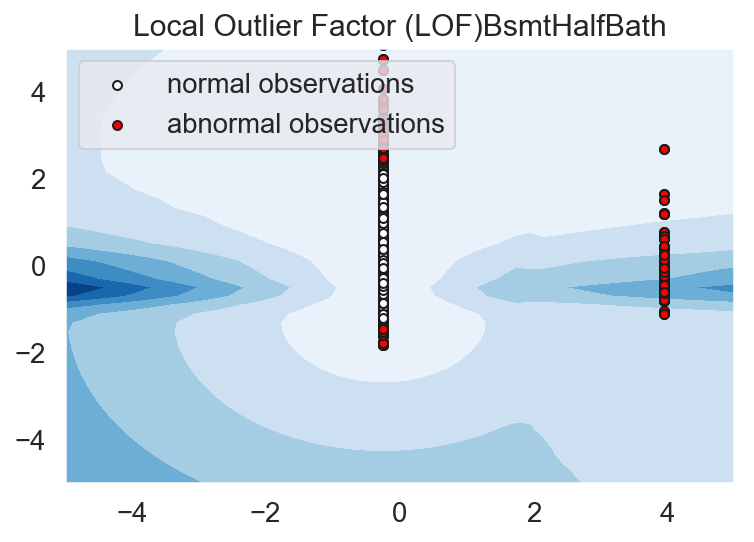

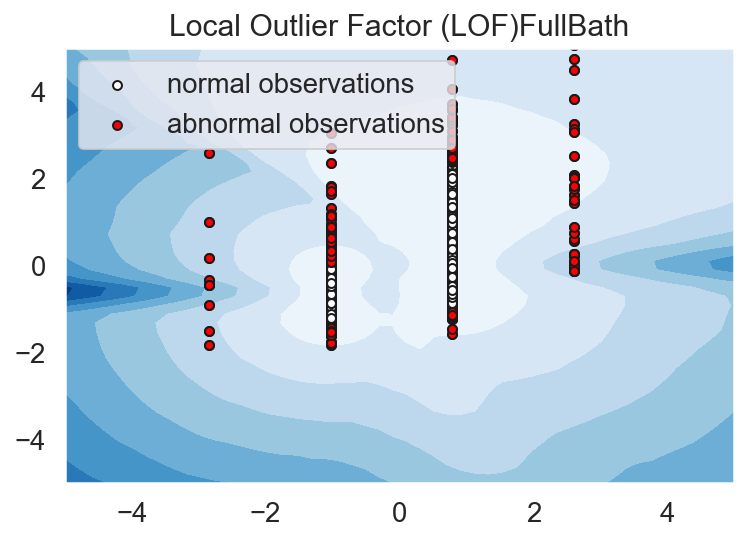

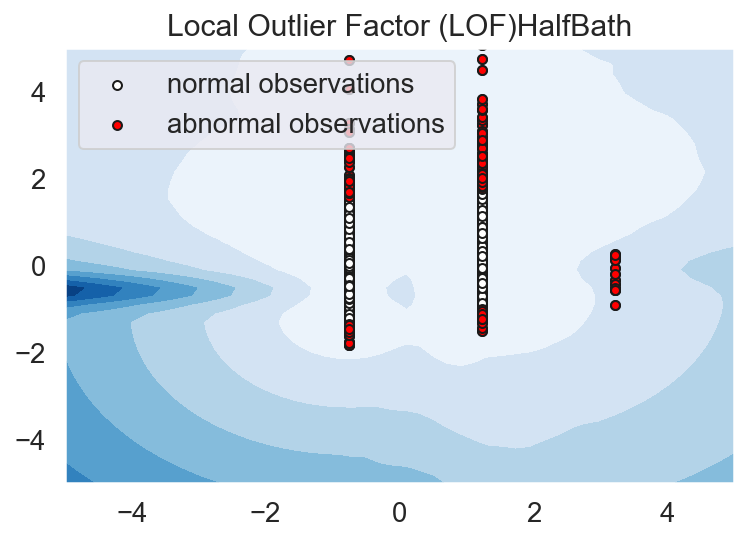

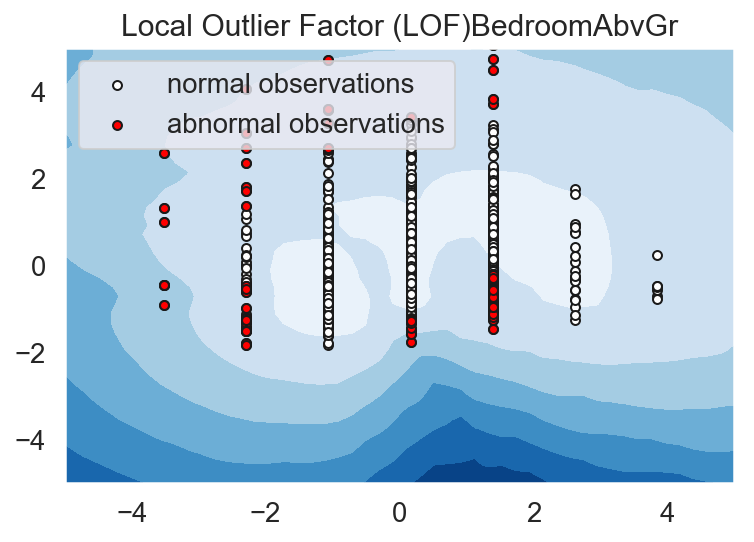

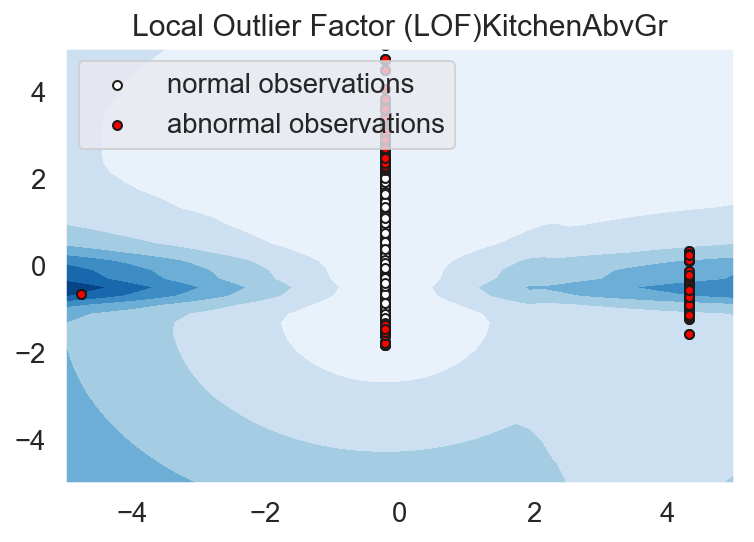

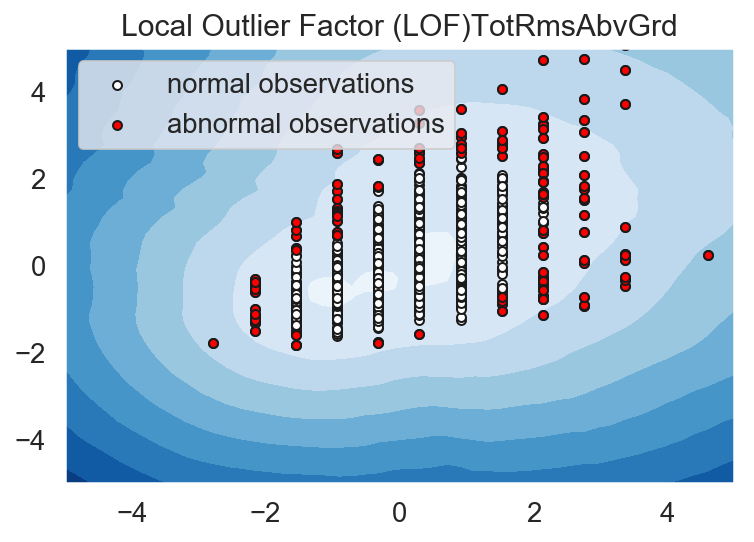

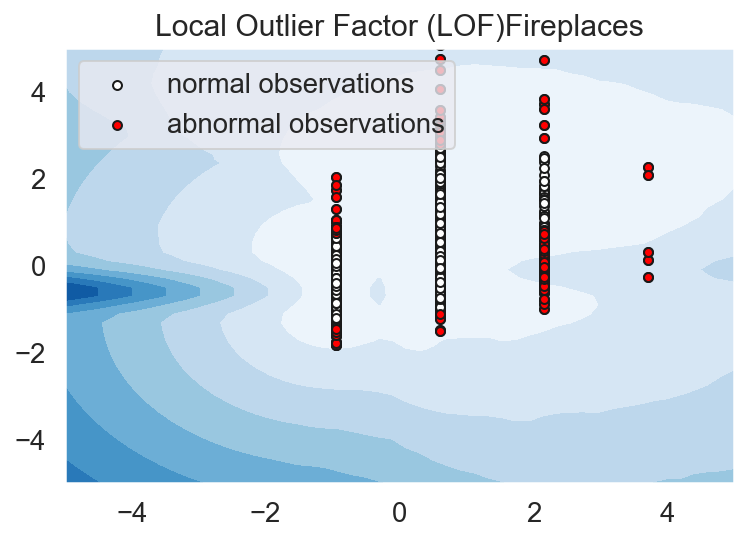

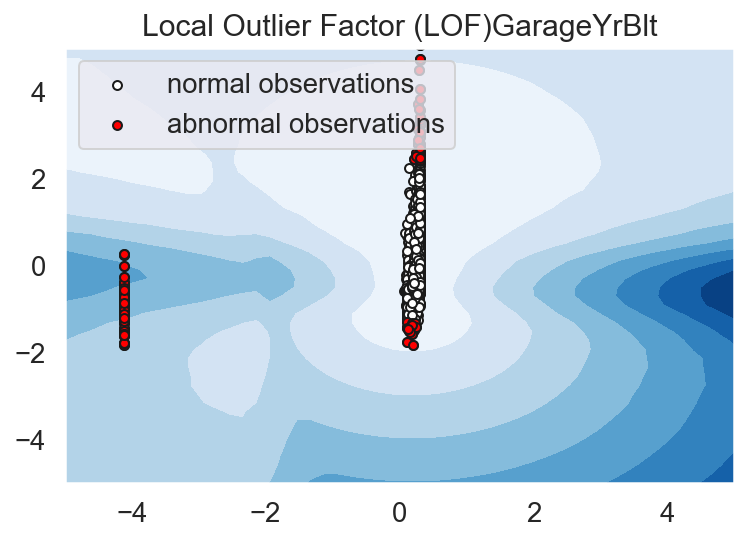

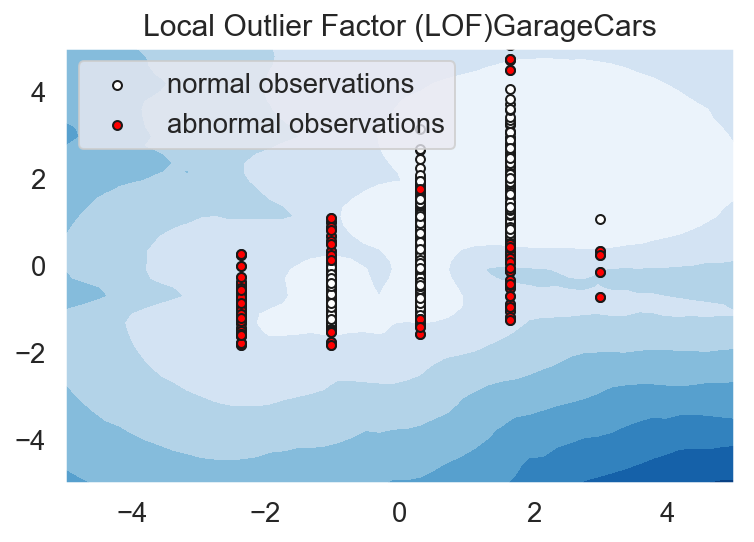

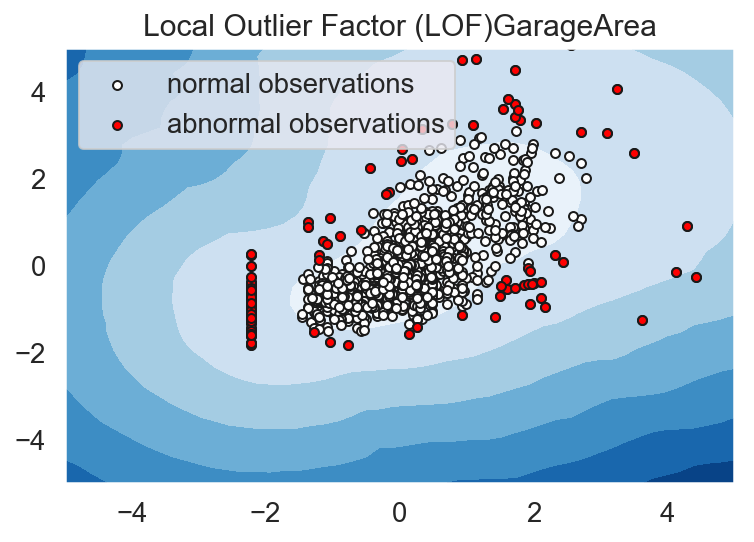

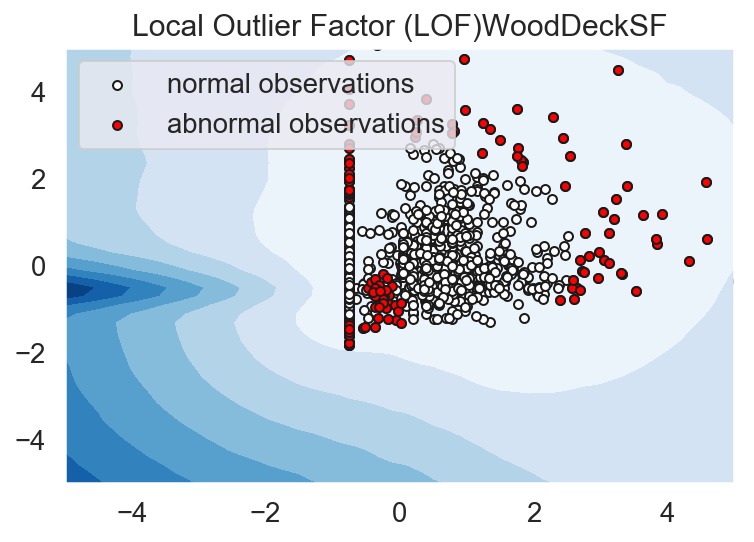

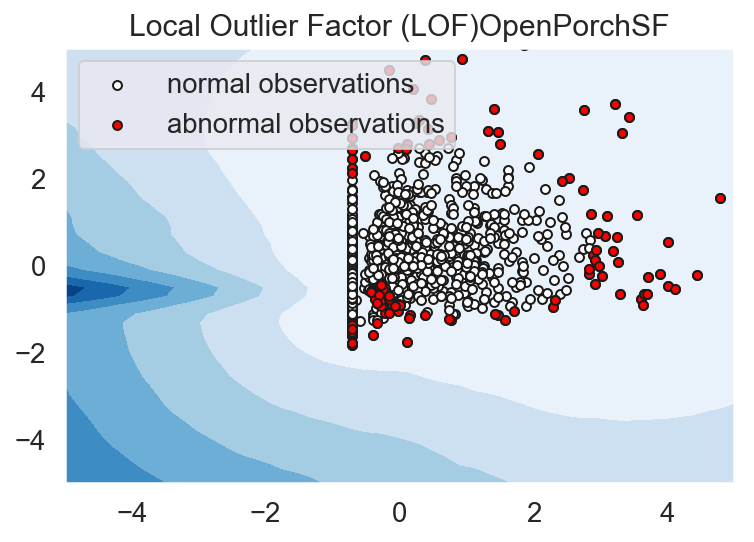

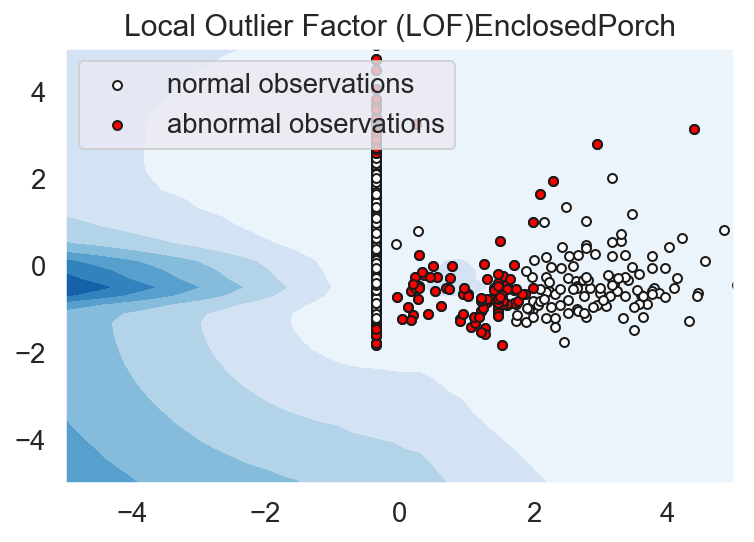

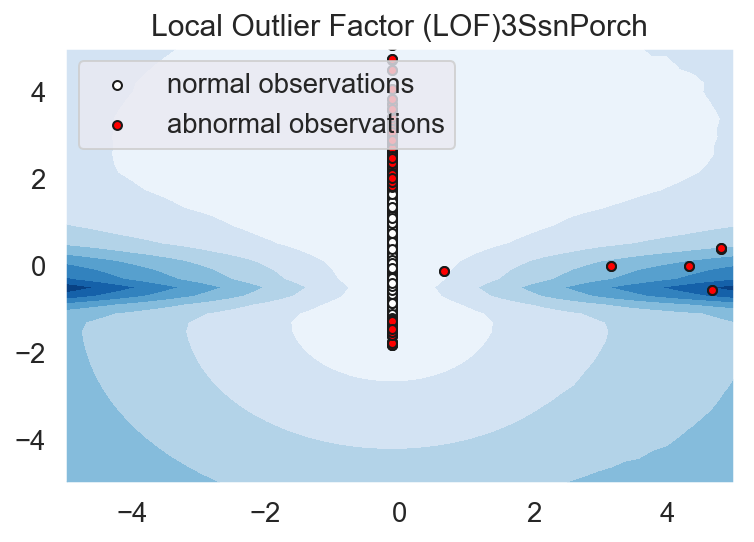

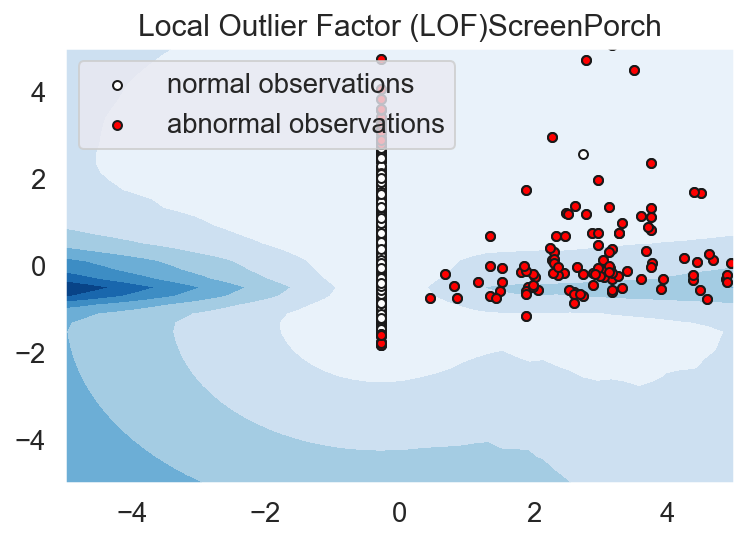

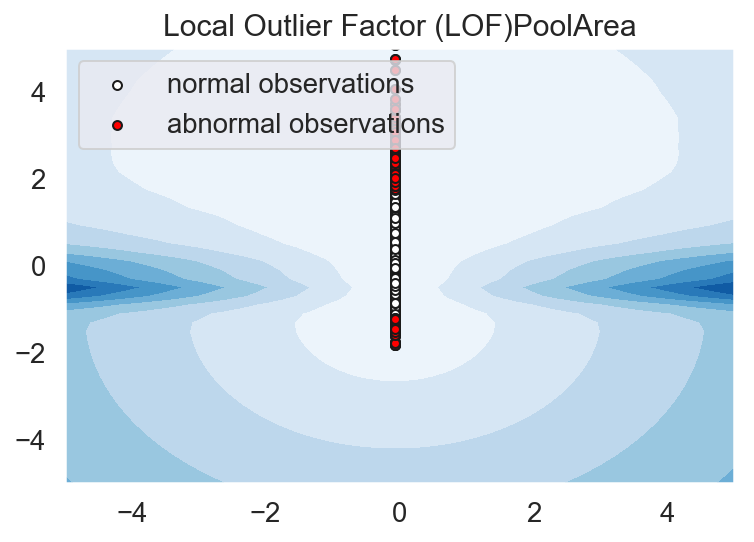

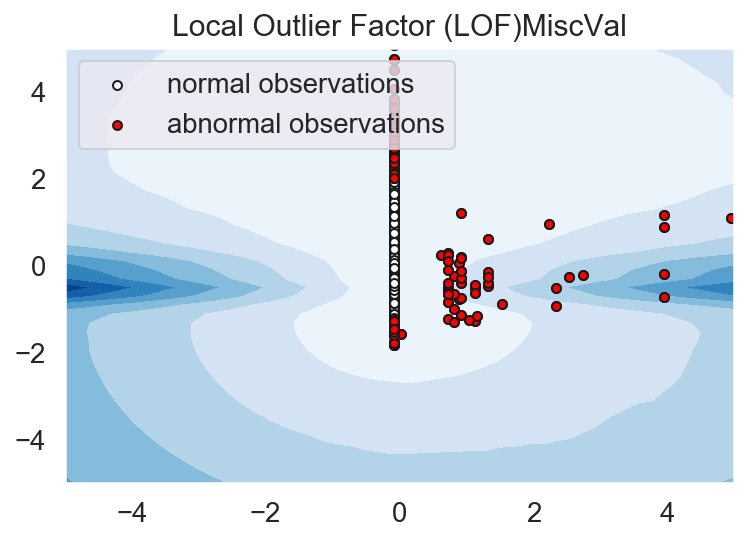

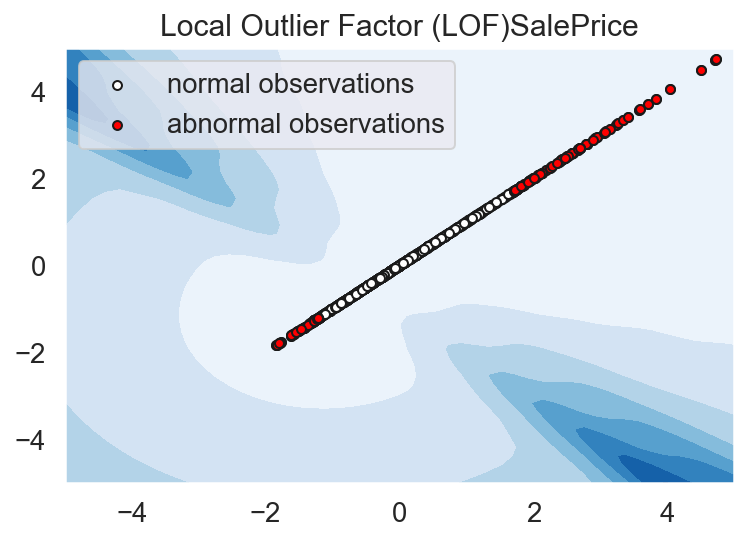

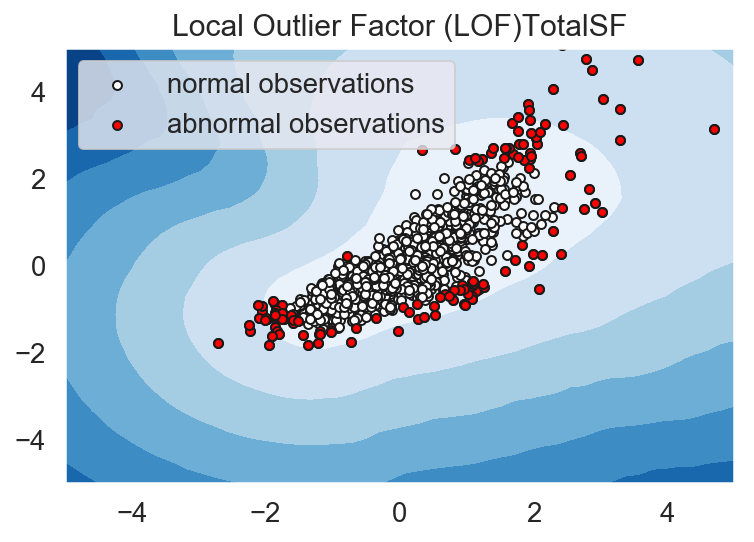

In [33]:
for numeric in floatcolumns:
    Test = df[[numeric,'SalePrice']]
    #Remember to Scale it first
    Scale.fit(Test)
    X = Scale.transform(Test)

   


    clf = LocalOutlierFactor(n_neighbors=200)
    y_pred = clf.fit_predict(X)
    y_pred_outliers = y_pred ==-1
    X_outliers = X[y_pred_outliers]
    # plot the level sets of the decision function
    xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
    Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.title("Local Outlier Factor (LOF)" + str(numeric))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

    a = plt.scatter(X[:, 0], X[:, 1], c='white',
                    edgecolor='k', s=20)
    b = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                    edgecolor='k', s=20)
    plt.axis('tight')
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([a, b],
               ["normal observations",
                "abnormal observations"],
               loc="upper left")
    plt.show()

In [34]:
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

Test = df[floatcolumns]
#Remember to Scale it first
Scale.fit(Test)
X = Scale.transform(Test)

# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X)
y_pred_train = clf.predict(X)



In [35]:
y_pred_train
Notoutliers = y_pred_train == 1
outliers = y_pred_train == -1

In [36]:
y_pred_train[Notoutliers] = 0

y_pred_train[outliers] =1

In [37]:
df['Outlier'] = y_pred_train

In [38]:
df['Outlier'].value_counts()

0    1314
1     146
Name: Outlier, dtype: int64

In [39]:
df.loc[df['Outlier'] ==1].index

Int64Index([   7,   39,   48,   53,   58,   70,   78,   88,   93,   99,
            ...
            1350, 1353, 1373, 1386, 1387, 1417, 1437, 1449, 1450, 1457],
           dtype='int64', length=146)

In [40]:
df_o= df.drop(df.loc[df['Outlier'] ==1].index)

In [41]:
datasets = [df,df_o]

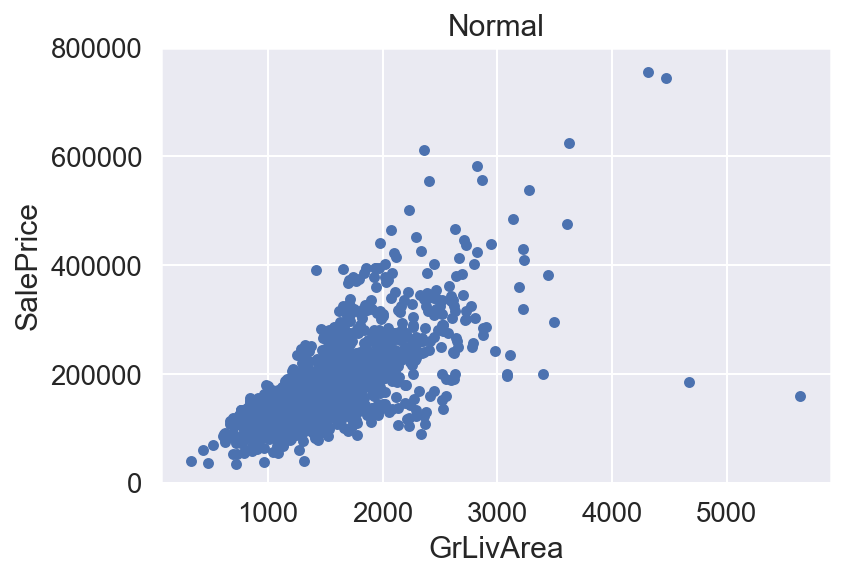

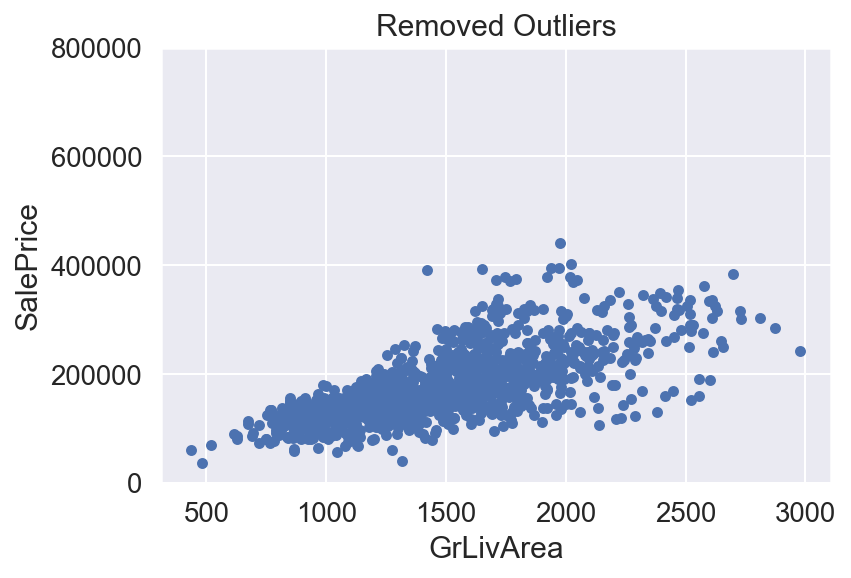

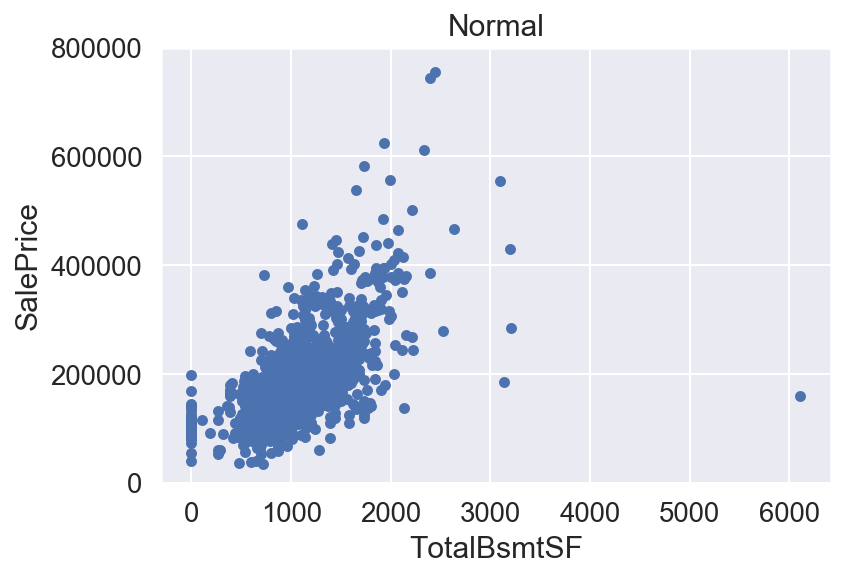

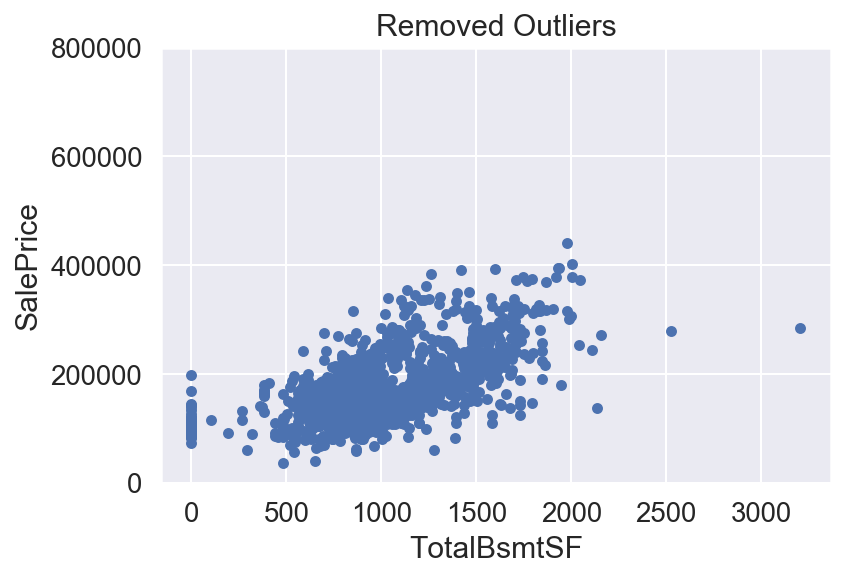

In [42]:
highcorr = ['GrLivArea','TotalBsmtSF']
for var in highcorr:
    for dataset ,title in zip(datasets,['Normal',"Removed Outliers"]):

        data = pd.concat([dataset['SalePrice'], dataset[var]], axis=1)
        data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))
        plt.title(str(title))
        plt.show()
        

In [43]:
NotCategorical = [notcategorical for notcategorical in df.columns if notcategorical not in categorical]

NotCategorical.remove("Outlier")

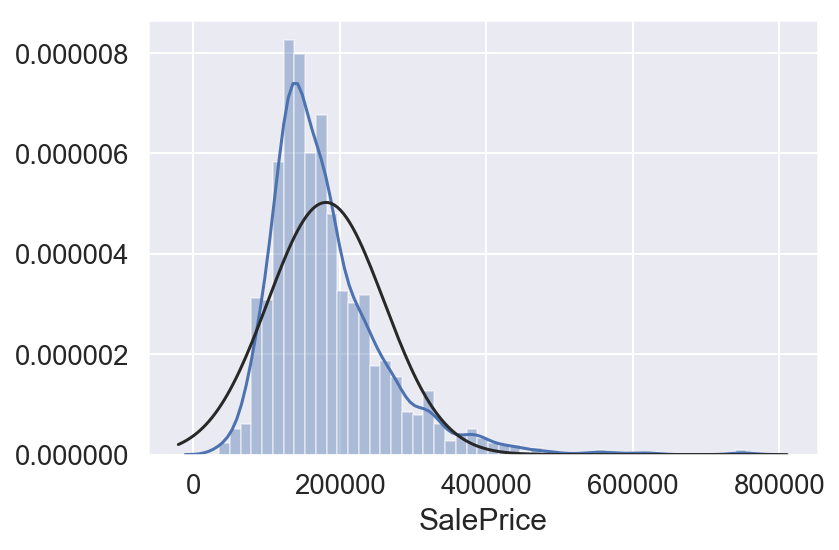

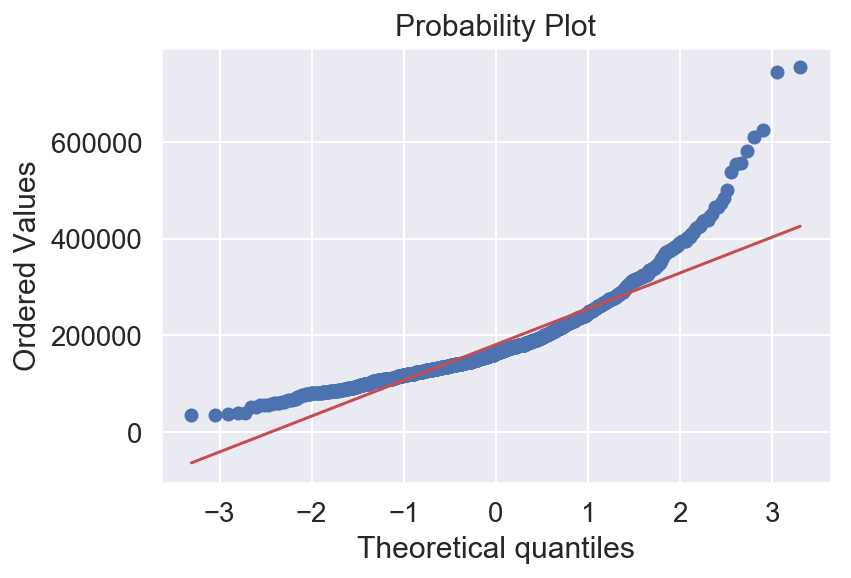

In [44]:
sns.distplot(df['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)

In [45]:
def fixskew(dataframe,column):
    dataframe[column]=np.log(dataframe[column])
    #defensive programming
    #Fix in case if it was turned from 0 to infinity(some columns have data which has a lot of 0)
    dataframe.loc[(dataframe[column] ==float("+inf") ) | (dataframe[column] ==float("-inf")),column] =0
    
    return dataframe

In [46]:
for dataframe in datasets:
    for nt in NotCategorical:
        dataframe = fixskew(dataframe,nt)

C:\Users\Serotonin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


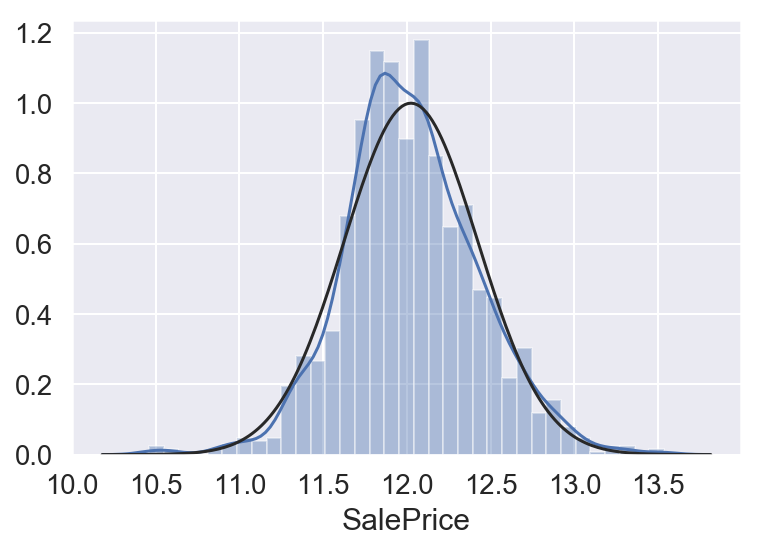

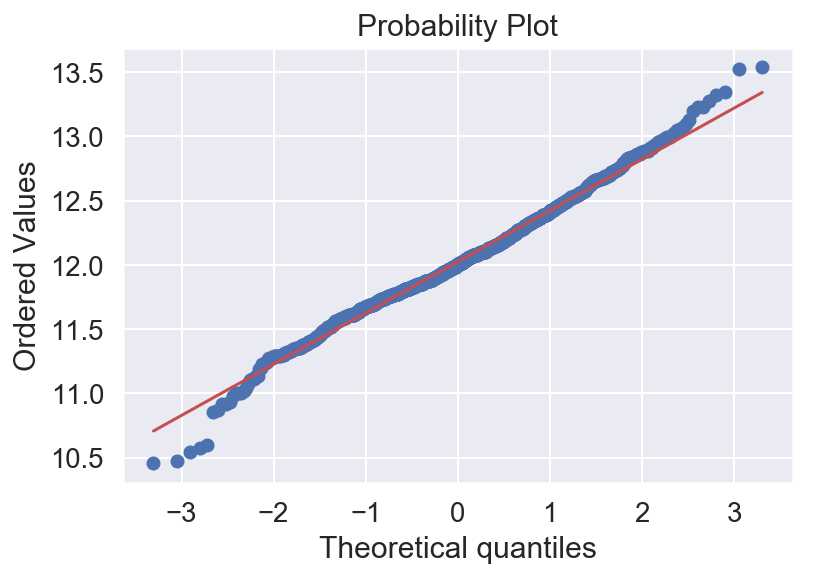

In [47]:
sns.distplot(df['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)

In [48]:
df_o.head()

Id MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0  0.000000         60       RL     4.174387  9.041922   Pave  None      Reg   
1  0.693147         20       RL     4.382027  9.169518   Pave  None      Reg   
2  1.098612         60       RL     4.219508  9.328123   Pave  None      IR1   
3  1.386294         70       RL     4.094345  9.164296   Pave  None      IR1   
4  1.609438         60       RL     4.430817  9.565214   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story     1.945910     1.609438   7.602401   
1       Norm     1Fam     1Story     1.791759     2.079442   7.588830   
2       Norm     1Fam     2Story     1.945910     1.609438   7.601402   
3       Norm     1Fam     2Story     1.945910     1.609438   7.557473   
4       Norm     1Fam     2Story     2.079442     1.609438   7.600902   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0      7.602401     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1      7.588830     Gable  CompShg     MetalSd     MetalSd       None   
2      7.601902     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3      7.585789     Gable  CompShg     Wd Sdng     Wd Shng       None   
4      7.600902     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0    5.278115        Gd        TA      PConc       Gd       TA           No   
1    0.000000        TA        TA     CBlock       Gd       TA           Gd   
2    5.087596        Gd        TA      PConc       Gd       TA           Mn   
3    0.000000        TA        TA     BrkTil       TA       Gd           No   
4    5.857933        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ    6.559615          Unf         0.0   5.010635     6.752270   
1          ALQ    6.885510          Unf         0.0   5.648974     7.140453   
2          GLQ    6.186209          Unf         0.0   6.073045     6.824374   
3          ALQ    5.375278          Unf         0.0   6.291569     6.628041   
4          GLQ    6.484635          Unf         0.0   6.194405     7.043160   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr  6.752270  6.749931           0.0   
1    GasA        Ex          Y      SBrkr  7.140453  0.000000           0.0   
2    GasA        Ex          Y      SBrkr  6.824374  6.763885           0.0   
3    GasA        Gd          Y      SBrkr  6.867974  6.628041           0.0   
4    GasA        Ex          Y      SBrkr  7.043160  6.959399           0.0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0   7.444249           0.0           0.0  0.693147       0.0      1.098612   
1   7.140453           0.0           0.0  0.693147       0.0      1.098612   
2   7.487734           0.0           0.0  0.693147       0.0      1.098612   
3   7.448334           0.0           0.0  0.000000       0.0      1.098612   
4   7.695303           0.0           0.0  0.693147       0.0      1.386294   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0           0.0          Gd      2.079442        Typ         0.0        None   
1           0.0          TA      1.791759        Typ         0.0          TA   
2           0.0          Gd      1.791759        Typ         0.0          TA   
3        

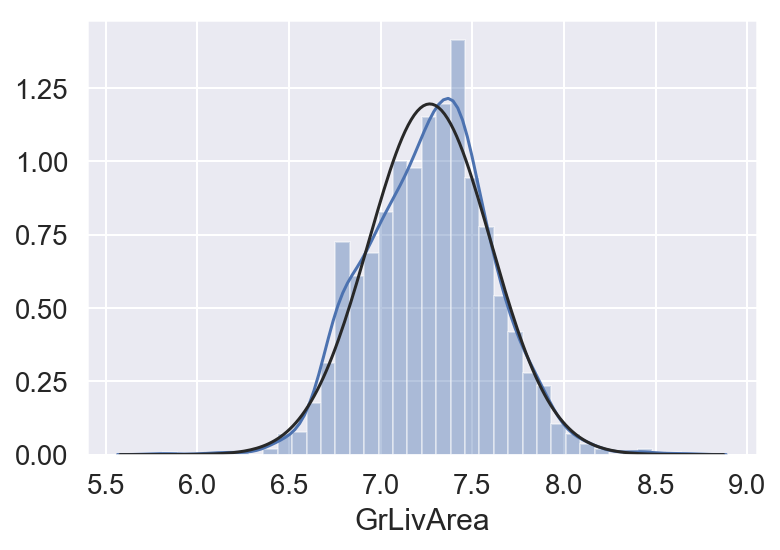

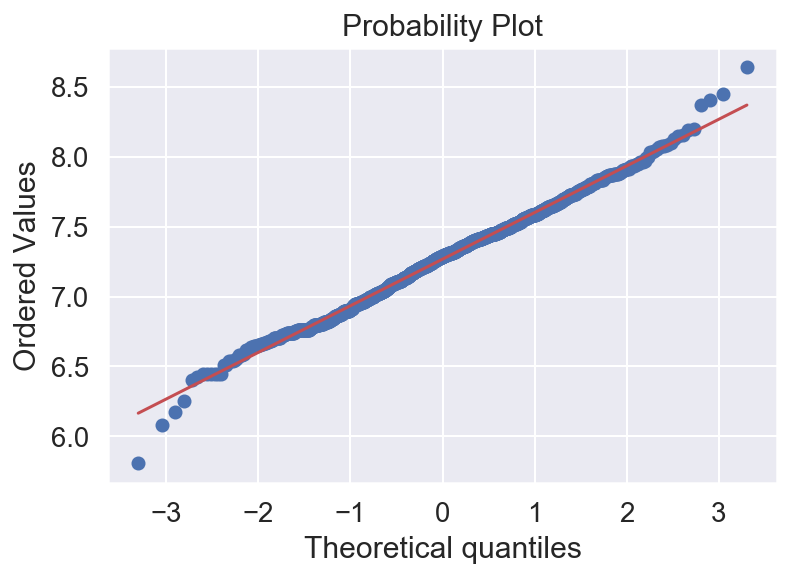

In [49]:
sns.distplot(df['GrLivArea'], fit=norm);

fig = plt.figure()
res = stats.probplot(df['GrLivArea'], plot=plt)

In [50]:
RB = RobustScaler(copy=True)

#Fit to the dataset that has outliers removed ( or tried to)
RB.fit(df_o[NotCategorical])

df[NotCategorical] = RB.transform(df[NotCategorical])
df_o[NotCategorical] = RB.transform(df_o[NotCategorical])

In [51]:
def getsaleprice(data):
    output = data.copy() # So as not to overwrite our precious engineered df
    output[NotCategorical] = np.exp(RB.inverse_transform(data[NotCategorical]))
    return output


In [52]:
getsaleprice(df)

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1.0         60       RL         65.0   8450.0   Pave  None      Reg   
1        2.0         20       RL         80.0   9600.0   Pave  None      Reg   
2        3.0         60       RL         68.0  11250.0   Pave  None      IR1   
3        4.0         70       RL         60.0   9550.0   Pave  None      IR1   
4        5.0         60       RL         84.0  14260.0   Pave  None      IR1   
5        6.0         50       RL         85.0  14115.0   Pave  None      IR1   
6        7.0         20       RL         75.0  10084.0   Pave  None      Reg   
7        8.0         60       RL          1.0  10382.0   Pave  None      IR1   
8        9.0         50       RM         51.0   6120.0   Pave  None      Reg   
9       10.0        190       RL         50.0   7420.0   Pave  None      Reg   
10      11.0         20       RL         70.0  11200.0   Pave  None      Reg   
11      12.0         60       RL         85.0  11924.0   Pave  None      IR1   
12      13.0         20       RL          1.0  12968.0   Pave  None      IR2   
13      14.0         20       RL         91.0  10652.0   Pave  None      IR1   
14      15.0         20       RL          1.0  10920.0   Pave  None      IR1   
15      16.0         45       RM         51.0   6120.0   Pave  None      Reg   
16      17.0         20       RL          1.0  11241.0   Pave  None      IR1   
17      18.0         90       RL         72.0  10791.0   Pave  None      Reg   
18      19.0         20       RL         66.0  13695.0   Pave  None      Reg   
19      20.0         20       RL         70.0   7560.0   Pave  None      Reg   
20      21.0         60       RL        101.0  14215.0   Pave  None      IR1   
21      22.0         45       RM         57.0   7449.0   Pave  Grvl      Reg   
22      23.0         20       RL         75.0   9742.0   Pave  None      Reg   
23      24.0        120       RM         44.0   4224.0   Pave  None      Reg   
24      25.0         20       RL          1.0   8246.0   Pave  None      IR1   
25      26.0         20       RL        110.0  14230.0   Pave  None      Reg   
26      27.0         20       RL         60.0   7200.0   Pave  None      Reg   
27      28.0         20       RL         98.0  11478.0   Pave  None      Reg   
28      29.0         20       RL         47.0  16321.0   Pave  None      IR1   
29      30.0         30       RM         60.0   6324.0   Pave  None      IR1   
...      ...        ...      ...          ...      ...    ...   ...      ...   
1430  1431.0         60       RL         60.0  21930.0   Pave  None      IR3   
1431  1432.0        120       RL          1.0   4928.0   Pave  None      IR1   
1432  1433.0         30       RL         60.0  10800.0   Pave  Grvl      Reg   
1433  1434.0         60       RL         93.0  10261.0   Pave  None      IR1   
1434  1435.0         20       RL         80.0  17400.0   Pave  None      Reg   
1435  1436.0         20       RL         80.0   8400.0   Pave  None      Reg   
1436  1437.0         20       RL         60.0   9000.0   Pave  None      Reg   
1437  1438.0         20       RL         96.0  12444.0   Pave  None      Reg   
1438  1439.0         20       RM         90.0   7407.0   Pave  None      Reg   
1439  1440.0         60       RL         80.0  11584.0   Pave  None      Reg   
1440  1441.0         70       RL         79.0  11526.0   Pave  None      IR1   
1441  1442.0        120       RM          1.0   4426.0   Pave  None      Reg   
1442  1443.0         60       FV         85.0  11003.0   Pave  None      Reg   
1443  1444.0         30       RL          1.0   8854.0   Pave  None      Reg   
1444  1445.0         20       RL         63.0   8500.0   Pave  None      Reg   
1445  1446.0         85       RL         70.0   8400.0   Pave  None      Reg   
1446  1447.0         20       RL          1.0  26142.0   Pave  None      IR1   
1447  1448.0         60       RL         80.0  10000.0   Pave  None      Reg   
1448  1449

In [53]:
dff =pd.concat([df[housedict['fixed']],df[['Outlier']],df[['SalePrice']]],axis=1)

## Feature Creation and Extraction

### Dummy variables for categories

In [54]:
def makedummy(df,category):
    output = pd.get_dummies(df[category])
    return output.drop(output.columns[0],axis=1) #We remove 1 so that if it's not 1, then it's the other.

In [55]:
for category in categorical:
    if category in dff.columns:
        dff = pd.concat([dff,makedummy(dff,category)],axis=1,join='outer', copy=False)
#Drop the old ones
dff.drop(categorical,axis=1,inplace=True,errors='ignore')

In [56]:
dff_o=dff.loc[dff['Outlier'] ==0].copy()
dff_o.dropna(inplace=True,axis=0) #Because it would have missing values for the outliers, so we are dropping the outliers

In [57]:
print(dff.shape)
print(dff_o.shape)

(1460, 154)
(1314, 154)


In [58]:
dff_x2010 = dff[getsaleprice(df)['YrSold']<2010].copy() #Train
#dff_ox2010 = dff_o[getsaleprice(df)['YrSold']<2010].copy() #Train without outliers

dff_2010 = dff[getsaleprice(df)['YrSold']>=2010].copy() #Test #Ground Truth

In [66]:
from sklearn.linear_model import ElasticNet, Lasso, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

### Training

In [60]:
y_train = dff_x2010['SalePrice']
X_train =dff_x2010.drop('SalePrice',axis=1)

In [61]:
y_test =dff_2010['SalePrice']
X_test = dff_2010.drop('SalePrice',axis=1)

### Cross validate function

In [62]:
def rmsle_cv(model,data,target,n_folds=5):
    kf = KFold(int(n_folds), shuffle=True, random_state=42).get_n_splits(data.values)
    rmse= np.sqrt(-cross_val_score(model, data.values, target.values, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


In [63]:
lasso =  Lasso(alpha =0.0005, random_state=1)
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
ENet = (ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [64]:
score = rmsle_cv(lasso,X_train,y_train)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


score = rmsle_cv(ENet,X_train,y_train)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR,X_train,y_train)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.3255 (0.0350)

ElasticNet score: 0.3261 (0.0350)

Kernel Ridge score: 0.3844 (0.0335)



In [67]:
optimal_lasso = LassoCV(n_alphas=500, cv=5, verbose=1)
Z = optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.02341309332915359


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [68]:
y_pred = Z.predict(X_test)


In [73]:
#cm = confusion_matrix(y_test, y_pred)

## im stuck

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [74]:
dfnew=df.copy()
dfnew.drop('Id',axis=1,inplace=True)

In [75]:
dfnew.head()

MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0         60       RL     0.049053 -0.248261   Pave  None      Reg   
1         20       RL     0.374960  0.062591   Pave  None      Reg   
2         60       RL     0.119874  0.448985   Pave  None      IR1   
3         70       RL    -0.076580  0.049869   Pave  None      IR1   
4         60       RL     0.451541  1.026585   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story     0.458138     0.000000   0.605312   
1       Norm     1Fam     1Story     0.000000     2.577883   0.021766   
2       Norm     1Fam     2Story     0.458138     0.000000   0.562357   
3       Norm     1Fam     2Story     0.458138     0.000000  -1.326524   
4       Norm     1Fam     2Story     0.854995     0.000000   0.540863   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0      0.241654     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1     -0.486598     Gable  CompShg     MetalSd     MetalSd       None   
2      0.214858     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3     -0.649783     Gable  CompShg     Wd Sdng     Wd Shng       None   
4      0.161224     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0    1.045869        Gd        TA      PConc       Gd       TA           No   
1    0.000000        TA        TA     CBlock       Gd       TA           Gd   
2    1.008118        Gd        TA      PConc       Gd       TA           Mn   
3    0.000000        TA        TA     BrkTil       TA       Gd           No   
4    1.160761        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ    0.091815          Unf         0.0  -0.897284    -0.296739   
1          ALQ    0.141586          Unf         0.0  -0.394838     0.557958   
2          GLQ    0.034788          Unf         0.0  -0.061045    -0.137983   
3          ALQ   -0.089059          Unf         0.0   0.110959    -0.570266   
4          GLQ    0.080364          Unf         0.0   0.034479     0.343739   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr -0.531333  1.028625           0.0   
1    GasA        Ex          Y      SBrkr  0.385308  0.000000           0.0   
2    GasA        Ex          Y      SBrkr -0.361071  1.030752           0.0   
3    GasA        Gd          Y      SBrkr -0.258114  1.010050           0.0   
4    GasA        Ex          Y      SBrkr  0.155563  1.060546           0.0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0   0.419639           0.0           0.0       0.0       0.0      0.000000   
1  -0.298902           0.0           0.0       0.0       0.0      0.000000   
2   0.522490           0.0           0.0       0.0       0.0      0.000000   
3   0.429301           0.0           0.0      -1.0       0.0      0.000000   
4   1.013435           0.0           0.0       0.0       0.0      0.709511   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0           0.0          Gd      0.854995        Typ         0.0        None   
1           0.0          TA      0.000000        Typ         0.0          TA   
2           0.0          Gd      0.000000        Typ         0.0          TA   
3           0.0          Gd      0.458138        Typ         0

In [76]:
#Dummy variables for categories
#Feature Creation and Extraction
for a in categorical:
    if a in dfnew.columns:
        dfnew = pd.concat([dfnew,makedummy(dfnew,a)],axis=1,join='outer')
#Drop the old ones
dfnew.drop(categorical,axis=1,inplace=True)

In [77]:
df_o=dfnew.loc[dfnew['Outlier'] ==0].copy()
df_o.dropna(inplace=True,axis=0) #Because it would have missing values for the outliers, so we are dropping the outliers

In [78]:
# A:
train = df_o[getsaleprice(df)['YrSold']<2010].copy() #Train without outliers
test = dfnew[getsaleprice(df)['YrSold']>=2010].copy() #Test #Ground Truth

C:\Users\Serotonin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [79]:
y_train2 = train['SalePrice']
X_train2= train.drop('SalePrice',axis=1,inplace=True)

In [80]:
y_test2 =test['SalePrice']
X_test2 =test.drop('SalePrice',axis=1,inplace=True)


In [81]:
score = rmsle_cv(lasso,train,y_train2)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


score = rmsle_cv(ENet,train,y_train2)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR,train,y_train2)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.2409 (0.0160)

ElasticNet score: 0.2415 (0.0160)

Kernel Ridge score: 0.2496 (0.0097)



<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [82]:
# A:
df['SaleCondition'].shape

(1460,)

In [83]:
dfnew['Abnormal'] = 0

In [84]:
dfnew.loc[df['SaleCondition'] !='Abnorml','Abnormal'] = 0
dfnew.loc[df['SaleCondition'] =='Abnorml','Abnormal'] =1
abnormals = dfnew.loc[df['SaleCondition'] =='Abnorml']
normal = dfnew.loc[df['SaleCondition'] !='Abnorml']

abnormalanswers = dfnew['Abnormal'].copy()


In [85]:
dfnew.drop('Abnormal',axis=1,inplace=True)

In [86]:
dfnew.head()

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     0.049053 -0.248261     0.458138     0.000000   0.605312      0.241654   
1     0.374960  0.062591     0.000000     2.577883   0.021766     -0.486598   
2     0.119874  0.448985     0.458138     0.000000   0.562357      0.214858   
3    -0.076580  0.049869     0.458138     0.000000  -1.326524     -0.649783   
4     0.451541  1.026585     0.854995     0.000000   0.540863      0.161224   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0    1.045869    0.091815         0.0  -0.897284    -0.296739 -0.531333   
1    0.000000    0.141586         0.0  -0.394838     0.557958  0.385308   
2    1.008118    0.034788         0.0  -0.061045    -0.137983 -0.361071   
3    0.000000   -0.089059         0.0   0.110959    -0.570266 -0.258114   
4    1.160761    0.080364         0.0   0.034479     0.343739  0.155563   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  1.028625           0.0   0.419639           0.0           0.0       0.0   
1  0.000000           0.0  -0.298902           0.0           0.0       0.0   
2  1.030752           0.0   0.522490           0.0           0.0       0.0   
3  1.010050           0.0   0.429301           0.0           0.0      -1.0   
4  1.060546           0.0   1.013435           0.0           0.0       0.0   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0       0.0      0.000000           0.0      0.854995         0.0   
1       0.0      0.000000           0.0      0.000000         0.0   
2       0.0      0.000000           0.0      0.000000         0.0   
3       0.0      0.000000           0.0      0.458138         0.0   
4       0.0      0.709511           0.0      1.205048         0.0   

   GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  \
0     0.594472    0.000000    0.277505    0.000000     0.224296   
1    -0.061072    0.000000   -0.077941    1.111853    -0.764160   
2     0.546217    0.000000    0.488478    0.000000     0.134559   
3     0.473744    0.584963    0.598968    0.000000     0.090720   
4     0.522072    0.584963    1.135116    1.026060     0.301226   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal    MoSold  \
0       0.000000        0.0          0.0       0.0      0.0 -2.337455   
1       0.000000        0.0          0.0       0.0      0.0 -0.387915   
2       0.000000        0.0          0.0       0.0      0.0  0.862685   
3       5.605802        0.0          0.0       0.0      0.0 -2.337455   
4       0.000000        0.0          0.0       0.0      0.0  1.474770   

     YrSold  SalePrice   TotalSF  Outlier  FV  RH  RL  RM  Pave  None  Pave  \
0  0.000000   0.544126  0.142721        0   0   0   1   0     1     1     0   
1 -0.500125   0.245083  0.098636        0   0   0   1   0     1     1     0   
2  0.000000   0.693929  0.284625        0   0   0   1   0     1     1     0   
3 -1.000498  -0.314720  0.044109        0   0   0   1   0     1     1     0   
4  0.000000   0.935541  0.849317        0   0   0   1   0     1     1     0   

   IR2  IR3  Reg  HLS  Low  Lvl  NoSeWa  CulDSac  FR2  FR3  Inside  Mod  Sev  \
0    0    0    1    0    0    1       0        0    0    0       1    0    0   
1    0    0    1    0    0    1       0        0    1    0       0    0    0   
2    0    0    0    0    0    1       0        0    0    0       1    0    0   
3    0    0    0    0    0    1       0        0    0    0       0    0    0   
4    0    0    0    0    0    1       0        0    1    0       0    0    0   

   Blueste  BrDale  BrkSide  ClearCr  CollgCr  Crawfor  Edwards  Gilbert  \
0        0       0        0        0        1        0        0        0   
1        0       0        0        0        0        0        0        0   
2        0       0        0        0        1        0        0        0   
3        0       0        0        0        0        1        0        0   
4        0     

### I dont know how to continue from here